In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import tqdm
warnings.filterwarnings("ignore")

In [2]:
SEED = 1337
np.random.seed(SEED)

In [3]:
SPLIT_DATE_TRAIN = "2020-01-01"
RADIUS = 300
THRESHOLD = 150 
BLOCK_SIZE = 0

In [4]:
df = pd.read_csv("../data/with_features_notmapped.csv")
df.dropna(inplace=True)
df

,time,longitude,latitude,depth,mag,magType,time_disc,longitude_disc,latitude_disc,pos,lat_cent,lon_cent,plate_region,dist_region,dist,plate,label
0,1973-01-01 01:05:56.150,-117.588000,34.189833,6.000,1.70,mh,1973-01-01,-118,34,34_-118,34.5,-117.5,na_pa,16.691592,19.302507,na_pa,0
1,1973-01-01 04:46:09.800,150.634000,-9.214000,41.000,5.30,mb,1973-01-01,150,-10,-10_150,-9.5,150.5,WL_au,21.124956,55.729840,WL_au,0
2,1973-01-01 05:20:59.780,-122.117333,48.308667,13.680,2.20,md,1973-01-01,-123,48,48_-123,48.5,-122.5,jf_na,296.114618,314.738391,jf_na,0
3,1973-01-01 06:22:29.800,-173.958000,-15.012000,33.000,5.00,mb,1973-01-01,-174,-16,-16_-174,-15.5,-173.5,NI_TO,84.317941,18.239739,NI_TO,0
4,1973-01-01 08:58:11.460,-155.360833,19.443667,7.302,1.85,ml,1973-01-01,-156,19,19_-156,19.5,-155.5,jf_pa,3527.668174,3522.498687,jf_pa,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4100001,2023-10-01 01:27:41.780,-179.015000,51.730000,10.980,1.22,ml,2023-10-01,-180,51,51_-180,51.5,-179.5,na_pa,113.570487,137.833943,na_pa,0
4100002,2023-10-01 01:30:30.046,152.699600,-4.342900,65.434,4.90,mb,2023-10-01,152,-5,-5_152,-4.5,152.5,NB_SB,39.066841,17.721537,NB_SB,0
4100003,2023-10-01 01:33:05.281,-152.662000,60.099900,109.400,1.90,ml,2023-10-01,-153,60,60_-153,60.5,-152.5,na_pa,397.084905,387.824459,na_pa,0
4100004,2023-10-01 01:41:39.645,-175.317600,51.902800,75.100,2.10,ml,2023-10-01,-176,51,51_-176,51.5,-175.5,na_pa,84.433512,123.080765,na_pa,0


In [5]:
df["label"].value_counts()

label
0    3851797
1     248209
Name: count, dtype: int64

In [6]:
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371.0
    lat1 = np.radians(lat1)
    lon1 = np.radians(lon1)
    lat2 = np.radians(lat2)
    lon2 = np.radians(lon2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = R * c
    return distance

In [7]:
def filter_regions(df: pd.DataFrame, threshold: int) -> pd.DataFrame:
    df_f = df[df["time"] <= SPLIT_DATE_TRAIN]
    df_agg = df_f.groupby(["pos"]).agg({"mag": "count"}).reset_index()
    regions = df_agg.loc[df_agg["mag"] >= threshold, "pos"].values
    return regions

In [8]:
def make_block(df, pos, radius, block_size):
    lat, lon = pos.split("_")
    lat, lon = float(lat), float(lon)
    tmp1 = df[df["pos"] == pos]
    diff = int(radius / 111) + 3
    tmp2 = df[((df["latitude"] >= lat - diff) & (df["latitude"] <= lat + diff) & (df["longitude"] >= lon - diff) & (df["longitude"] <= lon + diff)) & (df["pos"] != pos)]
    tmp2["label"] = -1
    tmp = pd.concat([tmp1, tmp2], axis=0)
    tmp["distance"] = haversine_distance(tmp["latitude"], tmp["longitude"], lat + 0.5, lon + 0.5)
    tmp = tmp[tmp["distance"] <= radius]
    tmp.sort_values(by=["time"], inplace=True)
    tmp["diff_days"] = (tmp["time"] - tmp["time"].shift(1)).dt.days
    for idx in range(1, block_size):
        tmp["mag_" + str(idx)] = tmp["mag"].shift(idx)
        tmp["depth_" + str(idx)] = tmp["depth"].shift(idx)
        tmp["latitude_" + str(idx)] = tmp["latitude"].shift(idx)
        tmp["longitude_" + str(idx)] = tmp["longitude"].shift(idx)
        tmp["dist_" + str(idx)] = tmp["dist"].shift(idx)
        tmp["distance_" + str(idx)] = tmp["distance"].shift(idx)
        tmp["plate_" + str(idx)] = tmp["plate"].shift(idx)
        tmp["diff_days_" + str(idx)] = tmp["diff_days"].shift(idx)
        tmp["magType_" + str(idx)] = tmp["magType"].shift(idx)
    tmp = tmp[tmp["label"] != -1]
    tmp.dropna(inplace=True)
    return tmp

In [9]:
def make_npys(df, radius, th, block_size):
    df["time"] = pd.to_datetime(df["time"], format="mixed")
    df.sort_values(by="time", inplace=True)
    regions = filter_regions(df, th)
    df_final = pd.DataFrame()
    for pos in tqdm.tqdm(regions):
        df_pos = make_block(df, pos, radius, block_size)
        df_final = pd.concat([df_final, df_pos], axis=0)
    return df_final

In [10]:
tmp = make_npys(df, RADIUS, THRESHOLD, BLOCK_SIZE)

 54%|█████▍    | 741/1362 [34:32<21:40:04, 125.61s/it]

In [ ]:
tmp

,time,longitude,latitude,depth,mag,magType,time_disc,longitude_disc,latitude_disc,pos,...,magType_2,mag_3,depth_3,latitude_3,longitude_3,dist_3,distance_3,plate_3,diff_days_3,magType_3
15925,1974-09-04 07:04:50.700,107.5700,-9.0340,69.0,5.4,ml,1974-09-04,107,-10,-10_107,...,ml,4.6,89.00,-7.3250,106.8680,226.896080,251.641020,au_su,39.0,ml
64356,1977-08-28 13:14:17.800,107.5430,-9.7050,33.0,4.4,md,1977-08-28,107,-10,-10_107,...,ml,5.2,113.00,-7.7750,109.1980,282.499732,267.644288,au_su,4.0,mb
146307,1981-02-24 02:00:05.320,107.4750,-9.2580,33.0,3.9,ml,1981-02-24,107,-10,-10_107,...,md,4.9,33.00,-8.2860,108.7010,213.626164,188.758711,au_su,27.0,ml
146868,1981-03-02 00:58:08.090,107.7460,-9.4560,33.0,5.1,ml,1981-03-02,107,-10,-10_107,...,ml,4.9,33.00,-8.7290,106.1980,57.414580,166.684068,au_su,85.0,md
166353,1981-09-10 09:12:52.040,107.7660,-9.6890,33.0,4.3,ml,1981-09-10,107,-10,-10_107,...,ml,5.7,33.00,-10.6810,107.9650,70.870604,140.842346,au_su,8.0,ml
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083544,2023-08-18 09:32:38.219,93.9692,9.1561,10.0,4.7,ml,2023-08-18,93,9,9_93,...,ml,4.3,96.53,7.3563,94.7353,29.142267,274.371027,BU_su,3.0,ml
4085825,2023-08-23 15:13:33.336,93.8083,9.0904,10.0,4.4,ml,2023-08-23,93,9,9_93,...,ml,4.7,10.00,9.5714,93.9359,34.712301,48.454984,BU_su,0.0,ml
4085829,2023-08-23 15:24:21.524,93.8846,9.1639,10.0,4.2,md,2023-08-23,93,9,9_93,...,ml,4.6,10.00,9.0272,93.9337,5.815454,70.917624,BU_su,0.0,ml
4089199,2023-09-01 07:27:51.913,93.8627,9.4069,10.0,4.2,ml,2023-09-01,93,9,9_93,...,md,4.4,10.00,9.0904,93.8083,21.066421,56.735666,BU_su,5.0,ml


In [ ]:
#tmp.to_csv("../data/feature_distribution.csv", index=False)

In [4]:
tmp = pd.read_csv("../data/feature_distribution.csv")

In [ ]:
tmp = pd.read_csv("../data/with_features_notmapped.csv")
tmp = tmp[tmp["time"] < SPLIT_DATE_TRAIN]

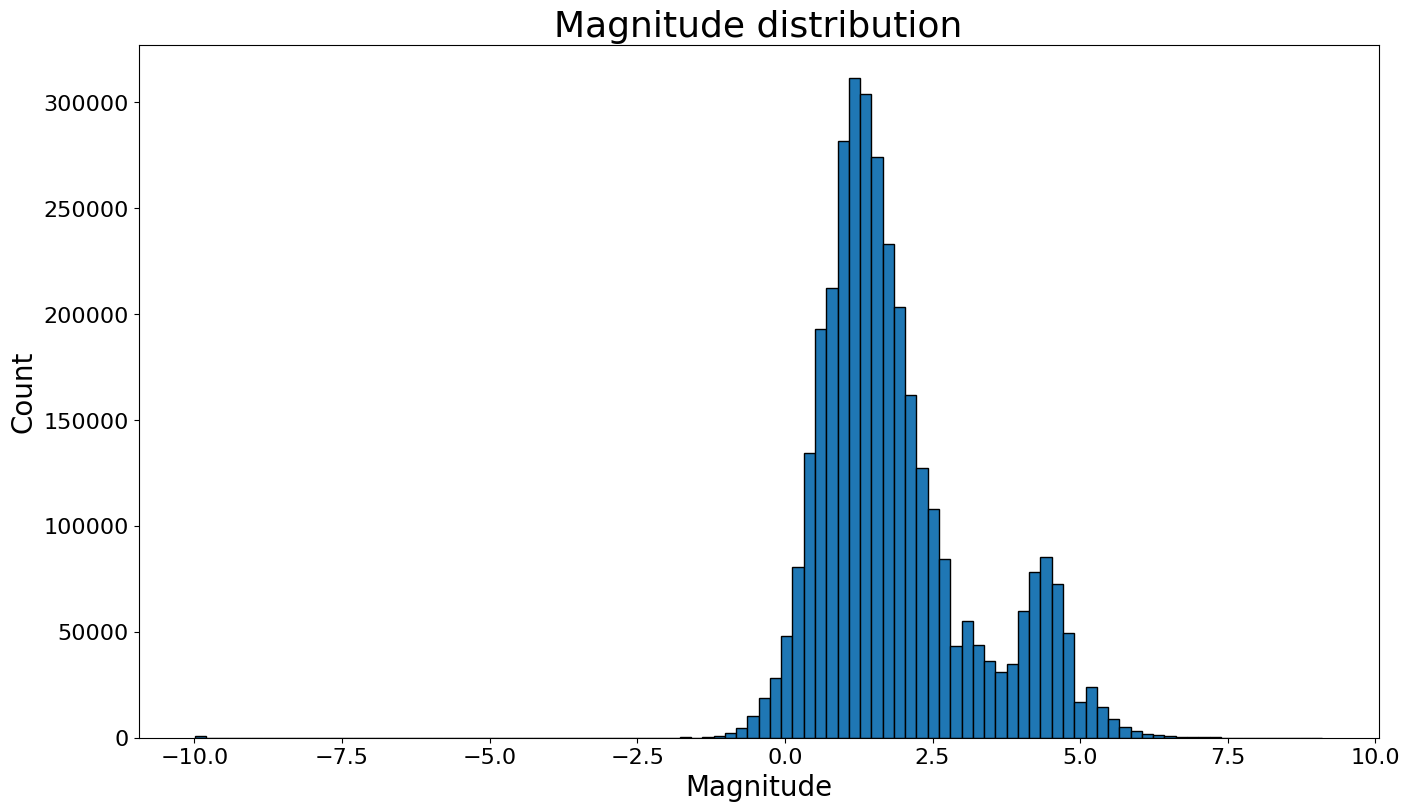

In [ ]:
tmp["mag"].hist(bins=100, edgecolor="black", figsize=(16, 9))
plt.title("Magnitude distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Magnitude", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

In [ ]:
len(tmp[(tmp["mag"] >= -1) & (tmp["mag"] <= 7)]) / len(tmp)

0.9992467103773385

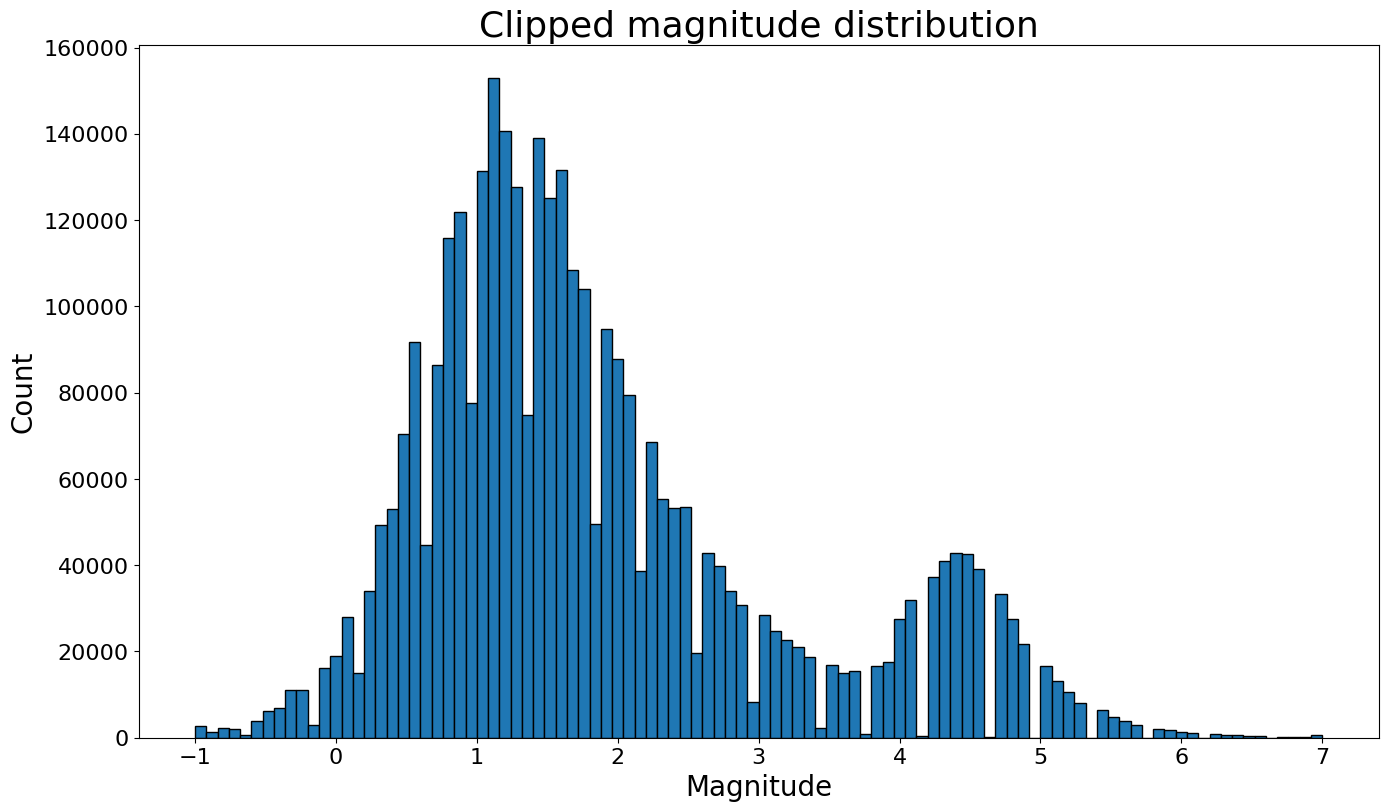

In [ ]:
d = np.clip(tmp["mag"].values, -1, 7)
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Clipped magnitude distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Magnitude", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

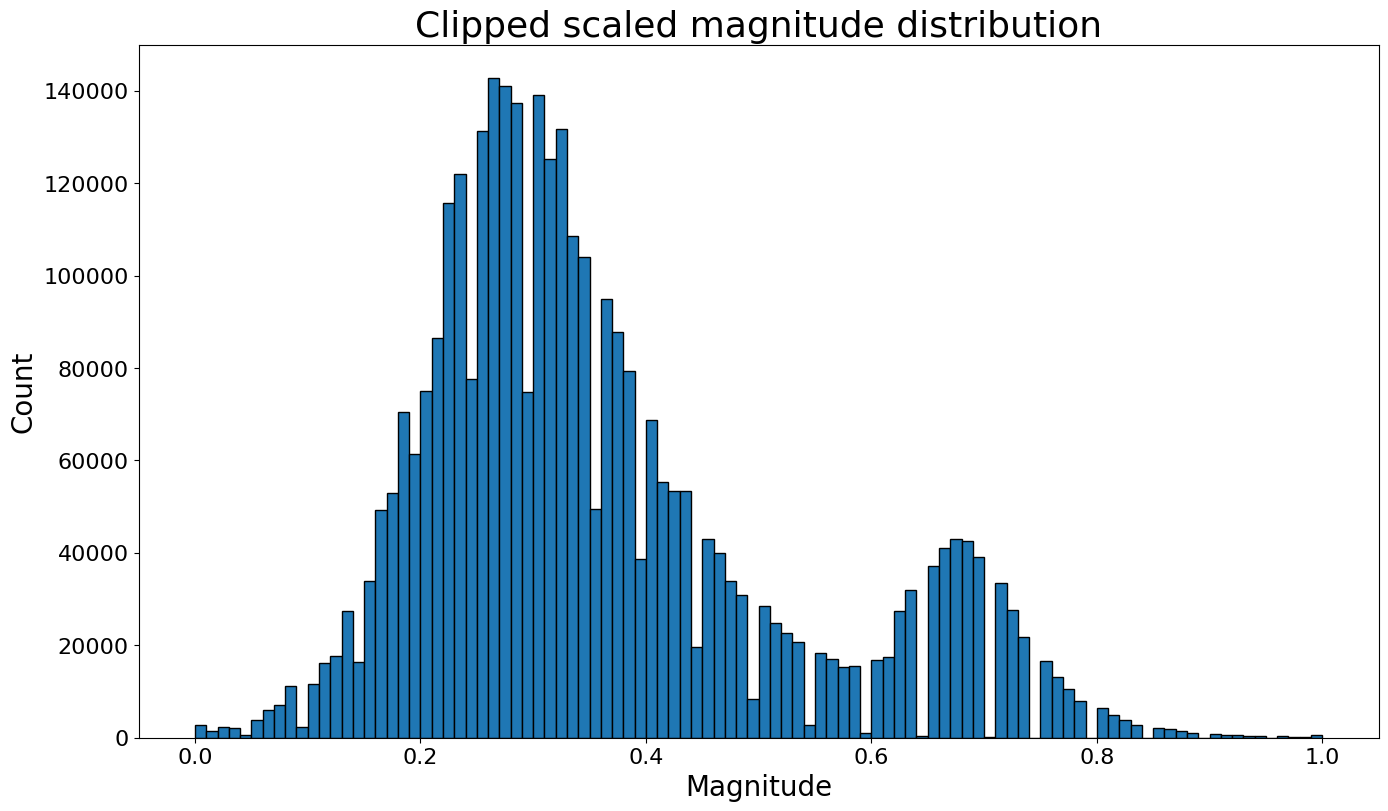

In [ ]:
sclaer = MinMaxScaler()
d = sclaer.fit_transform(d.reshape(-1, 1))
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Clipped scaled magnitude distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Magnitude", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

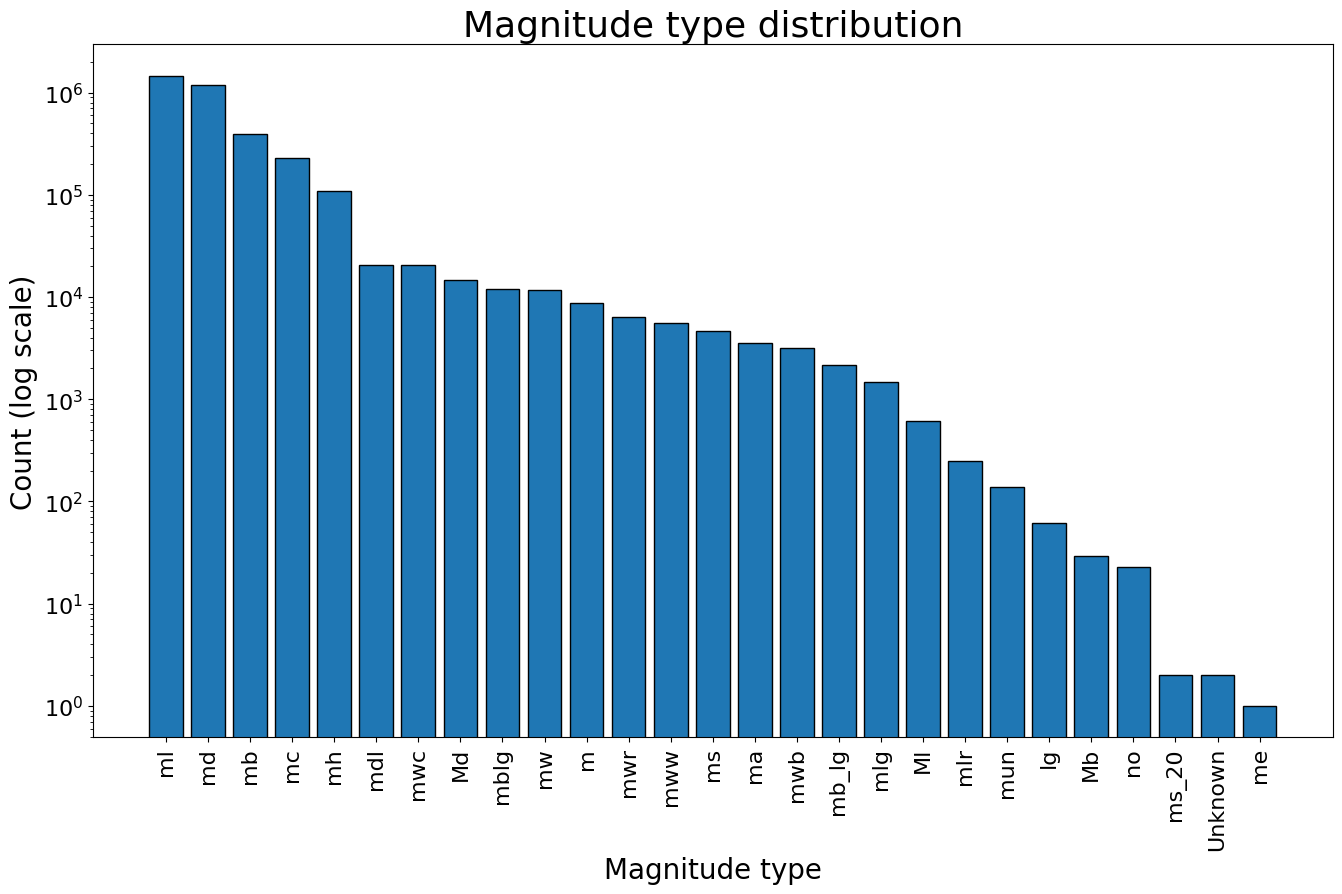

In [ ]:
plt.figure(figsize=(16, 9))
plt.bar(tmp["magType"].value_counts().index, tmp["magType"].value_counts().values, edgecolor="black")
plt.title("Magnitude type distribution", fontsize=26)
plt.ylabel("Count (log scale)", fontsize=20)
plt.xlabel("Magnitude type", fontsize=20)
plt.yscale("log")
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.show()

In [ ]:
n = 17
mag_type_dict = dict(zip(tmp["magType"].value_counts().index[n:], ["other"] * len(tmp["magType"].value_counts().index[n:])))
mag_type_dict.update(dict(zip(tmp["magType"].value_counts().index[:n], tmp["magType"].value_counts().index[:n])))
tmp["magType_id"] = tmp["magType"].map(mag_type_dict)

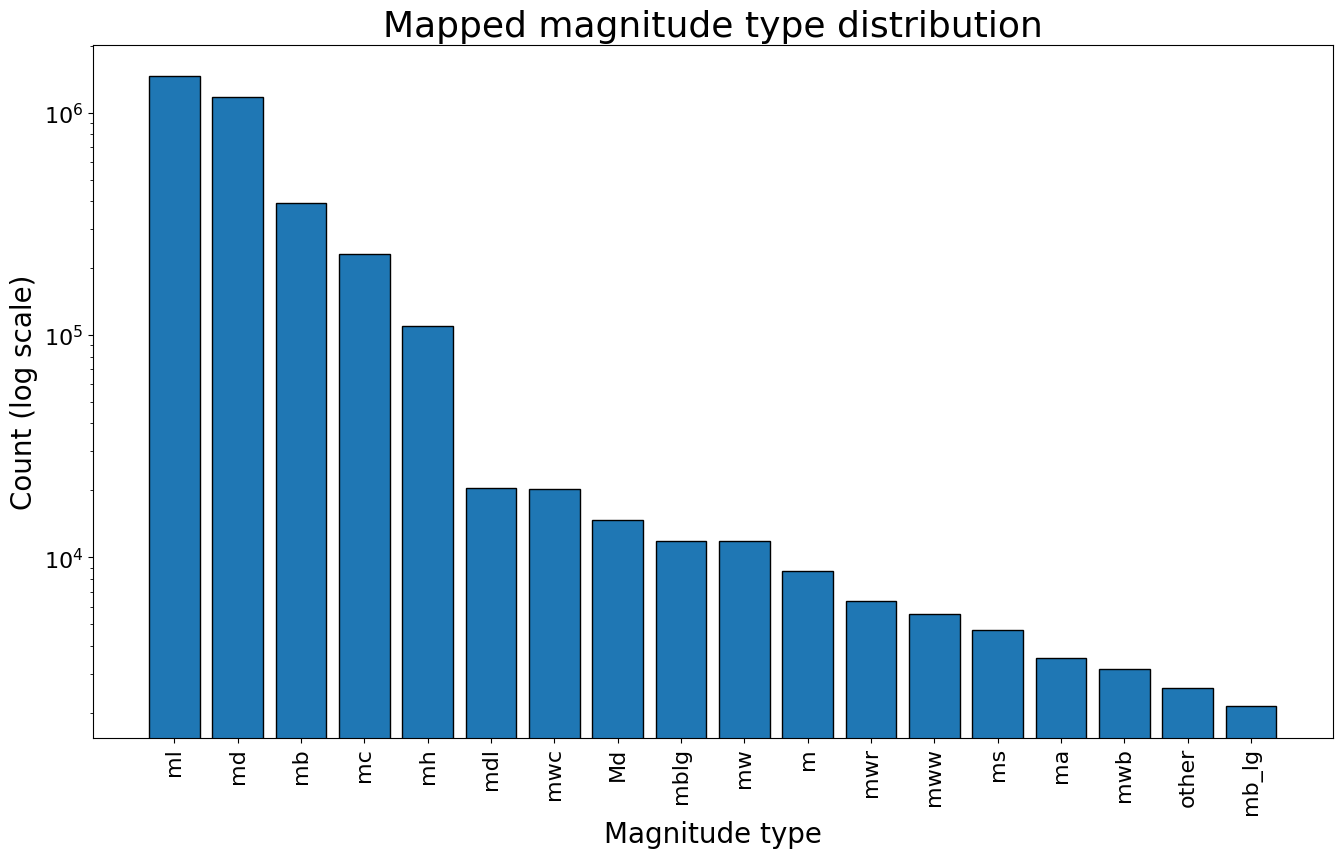

In [ ]:
plt.figure(figsize=(16, 9))
plt.bar(tmp["magType_id"].value_counts().index, tmp["magType_id"].value_counts().values, edgecolor="black")
plt.title("Mapped magnitude type distribution", fontsize=26)
plt.ylabel("Count (log scale)", fontsize=20)
plt.xlabel("Magnitude type", fontsize=20)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.yscale("log")
plt.show()

In [ ]:
tmp["magType_id"].value_counts()

magType_id
ml       1459811
md       1180216
mb        391406
mc        231300
mh        109939
mdl        20590
mwc        20379
Md         14707
mblg       11853
mw         11788
m           8661
mwr         6350
mww         5585
ms          4697
ma          3538
mwb         3144
other       2590
mb_lg       2144
Name: count, dtype: int64

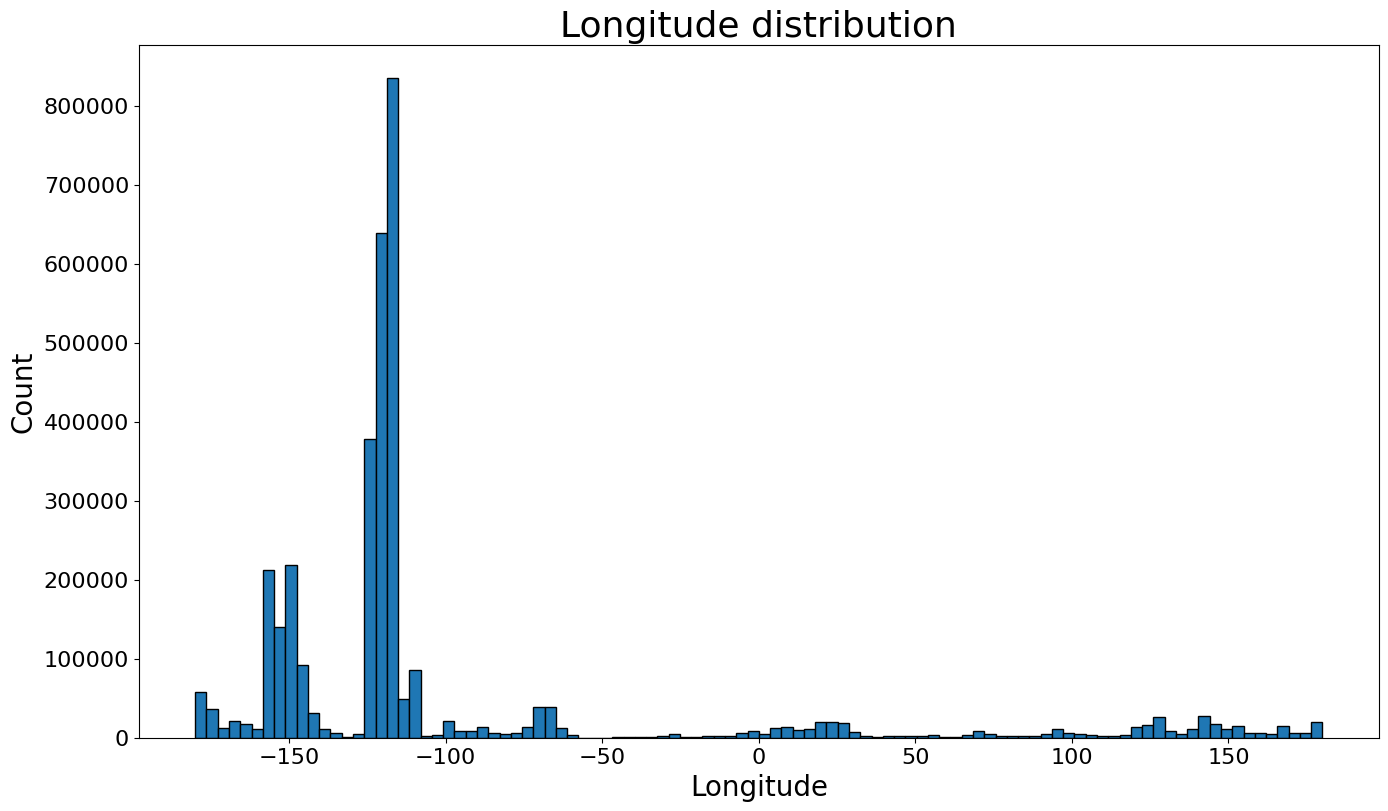

In [ ]:
tmp["longitude"].hist(bins=100, edgecolor="black", figsize=(16, 9))
plt.title("Longitude distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Longitude", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

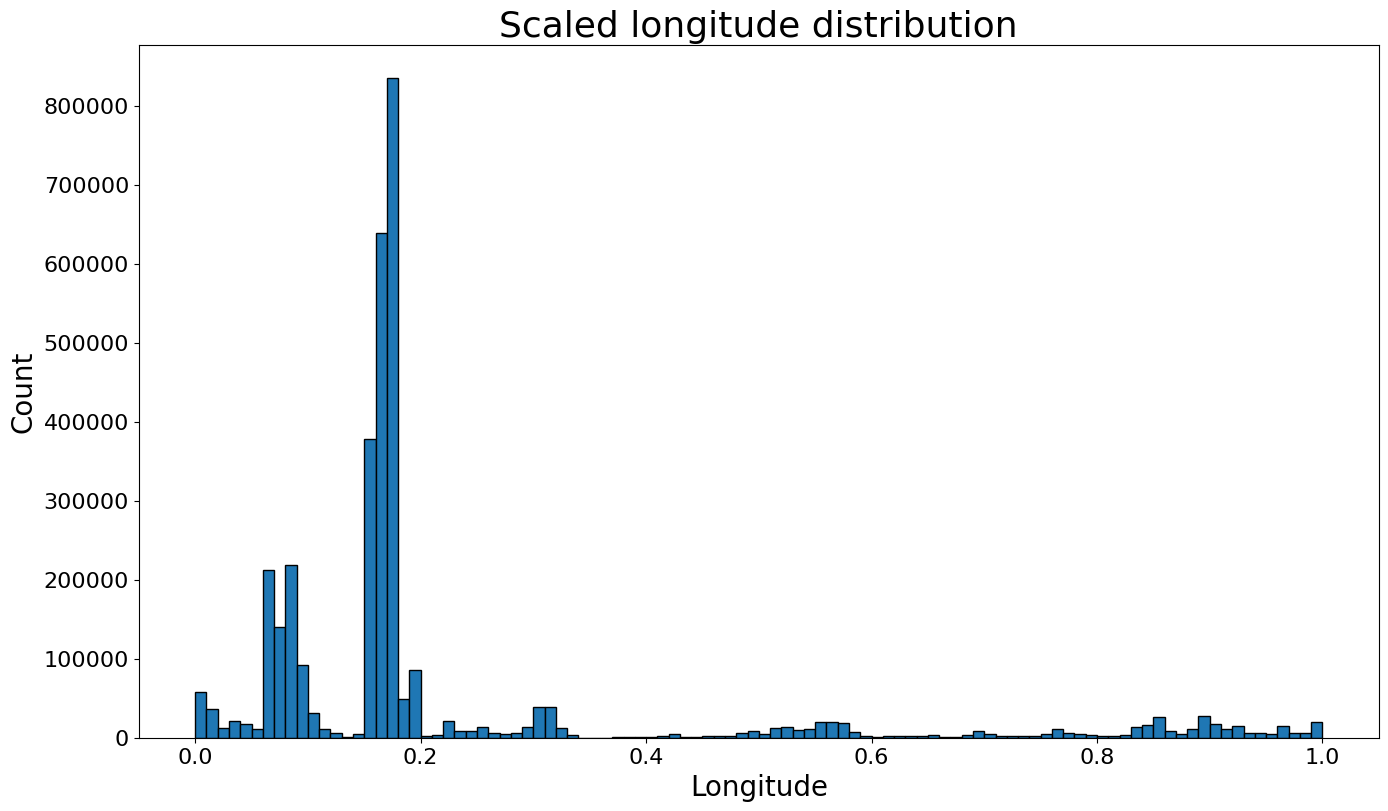

In [ ]:
scaler = MinMaxScaler()
d = scaler.fit_transform(tmp["longitude"].values.reshape(-1, 1))
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Scaled longitude distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Longitude", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

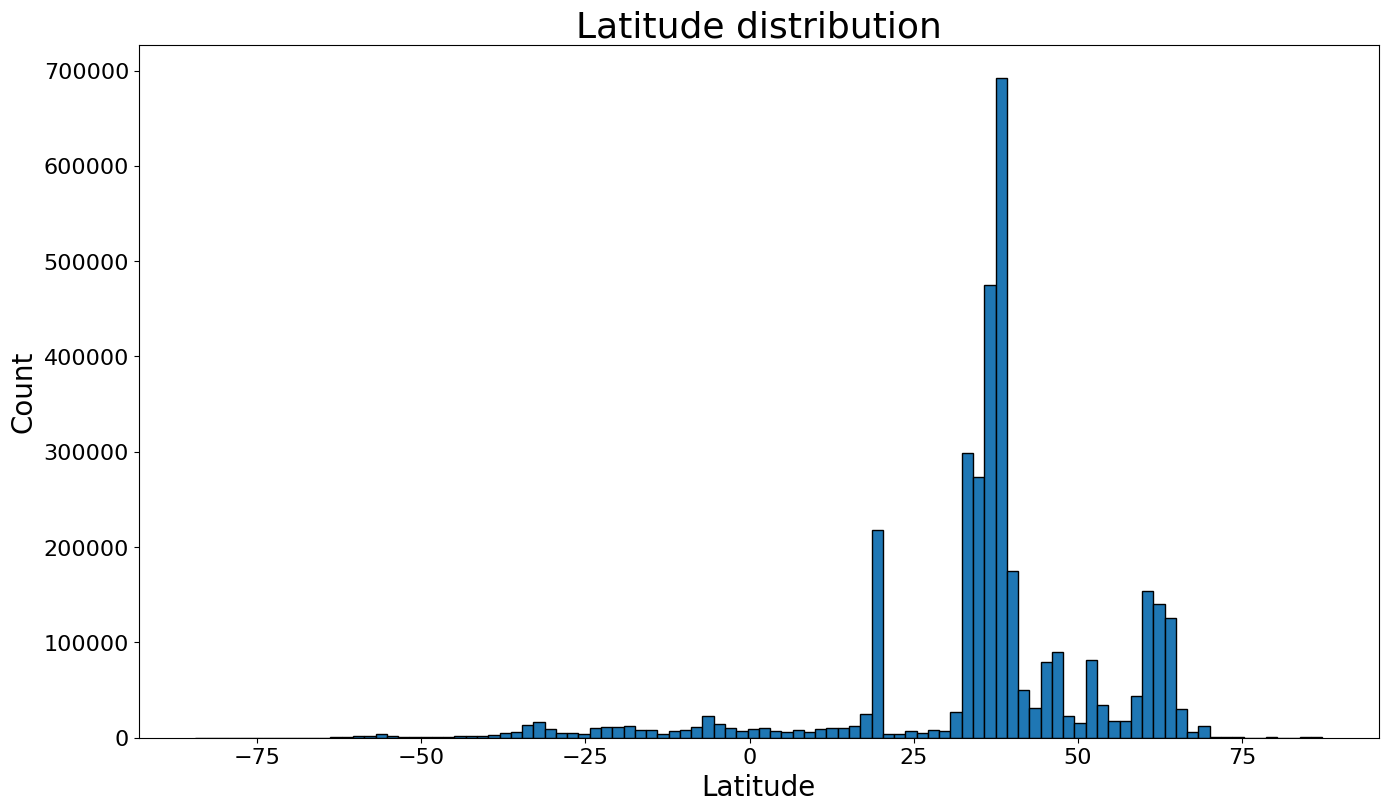

In [ ]:
tmp["latitude"].hist(bins=100, edgecolor="black", figsize=(16, 9))
plt.title("Latitude distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Latitude", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

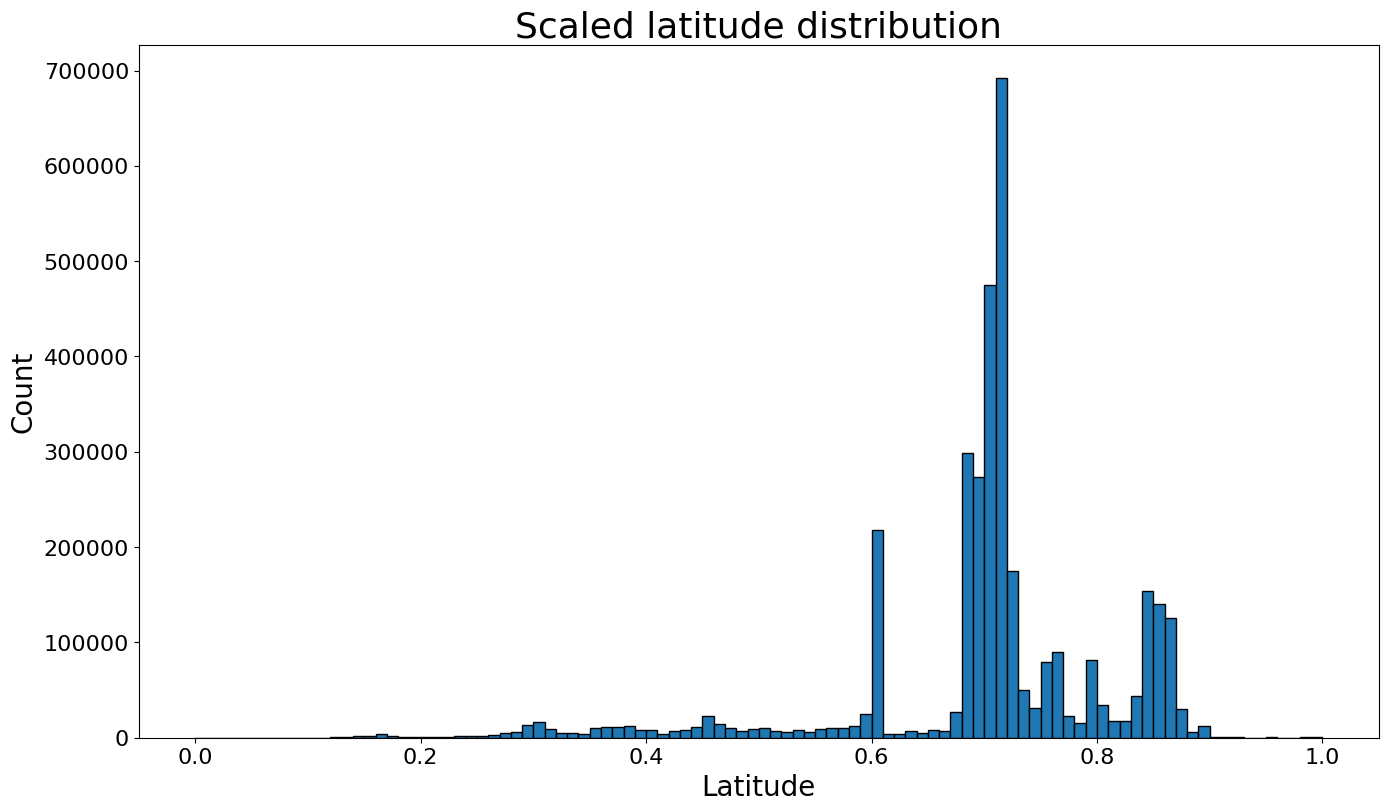

In [ ]:
scaler = MinMaxScaler()
d = scaler.fit_transform(tmp["latitude"].values.reshape(-1, 1))
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Scaled latitude distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Latitude", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

In [ ]:
tmp["depth"].quantile(0.98)

149.25

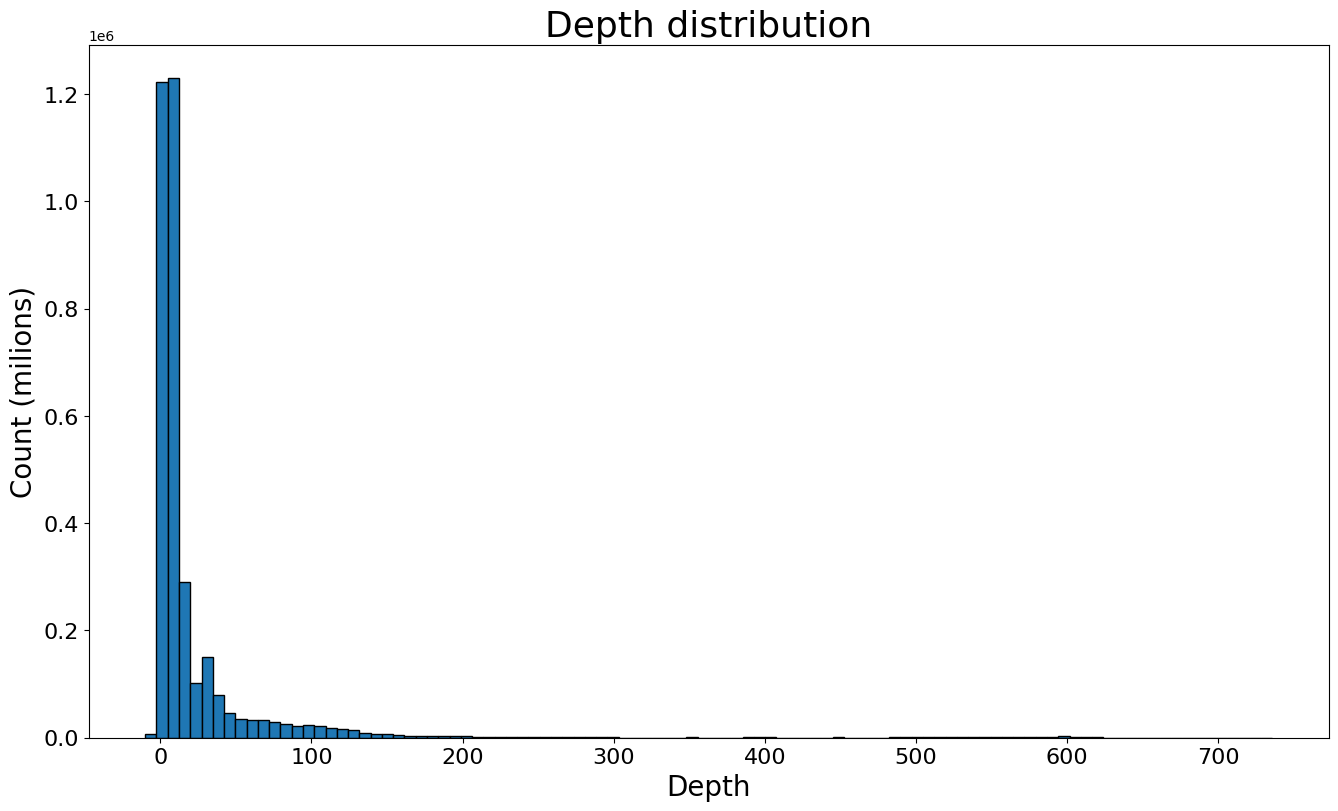

In [ ]:
tmp["depth"].hist(bins=100, edgecolor="black", figsize=(16, 9))
plt.title("Depth distribution", fontsize=26)
plt.ylabel("Count (milions)", fontsize=20)
plt.xlabel("Depth", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

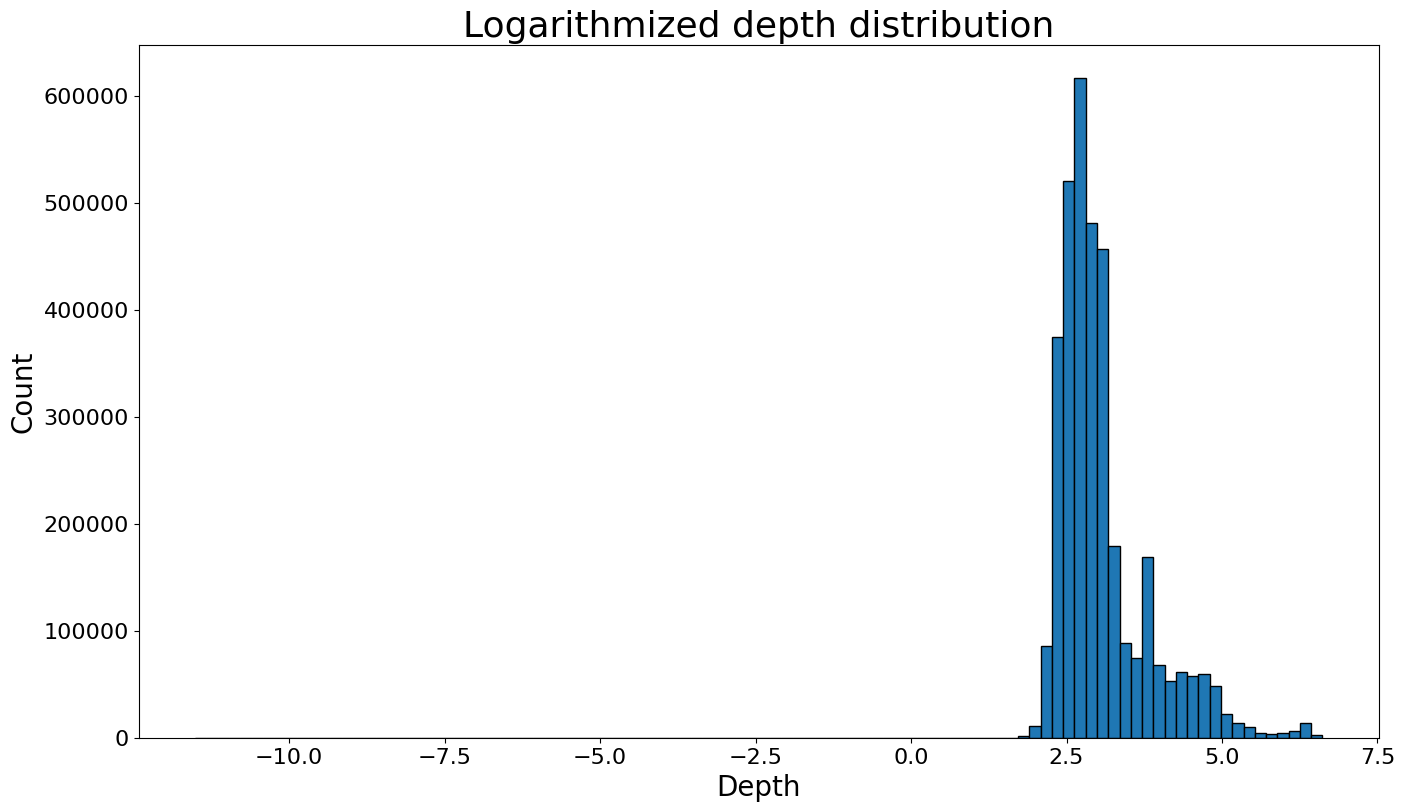

In [ ]:
d = np.log(tmp["depth"] + np.abs(tmp["depth"].min()) + 1e-5)
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Logarithmized depth distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Depth", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

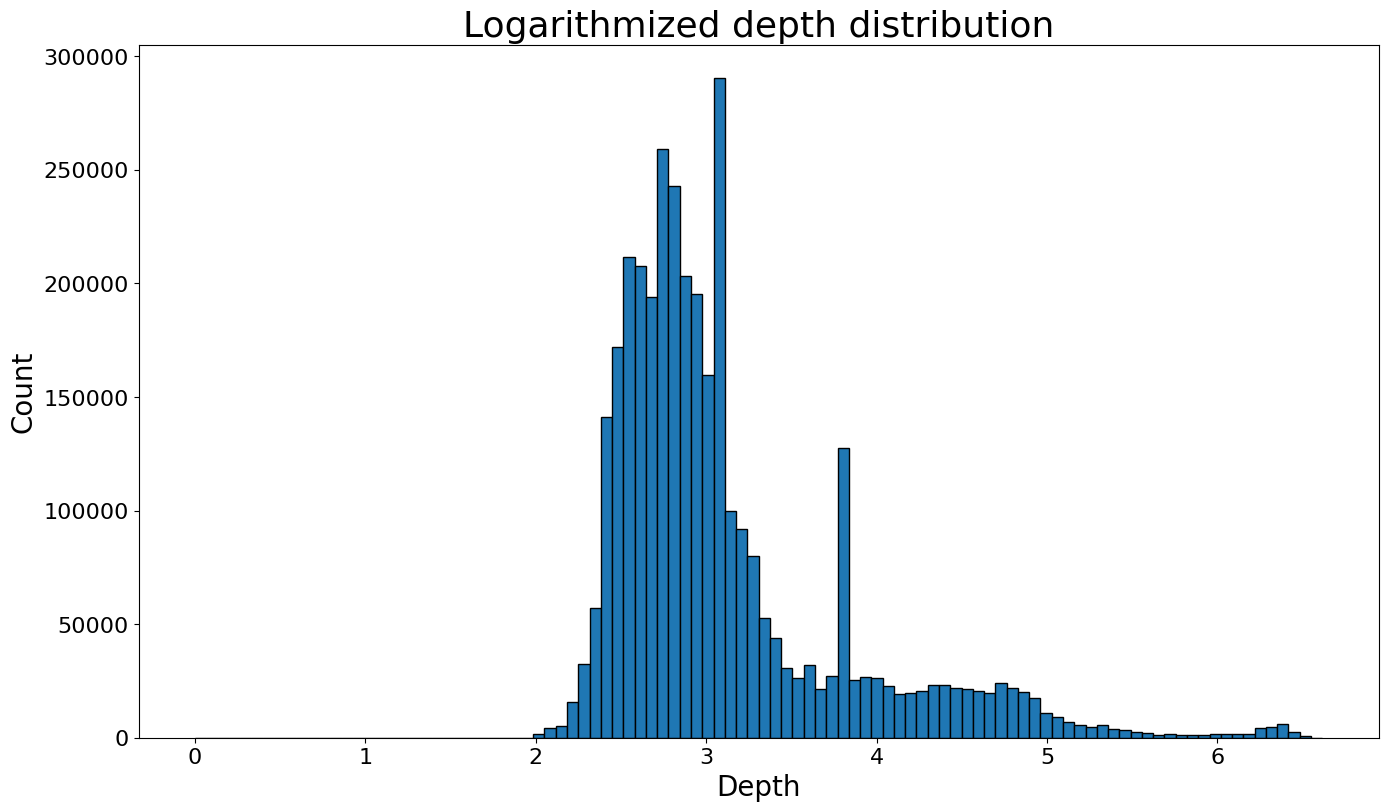

In [ ]:
d = np.log(tmp["depth"] + np.abs(tmp["depth"].min()) + 1)
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Logarithmized depth distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Depth", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

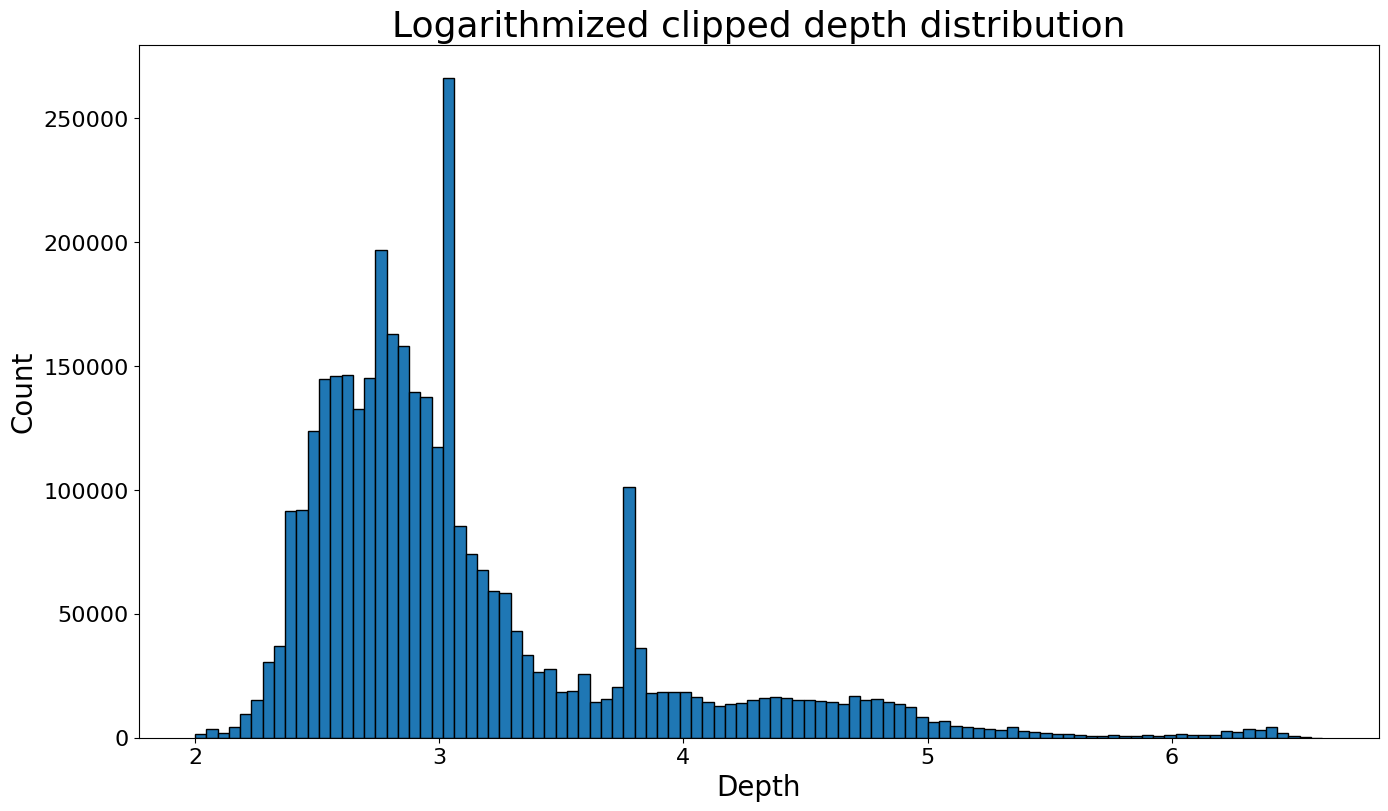

In [ ]:
d = np.clip(d, 2, 10)
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Logarithmized clipped depth distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Depth", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

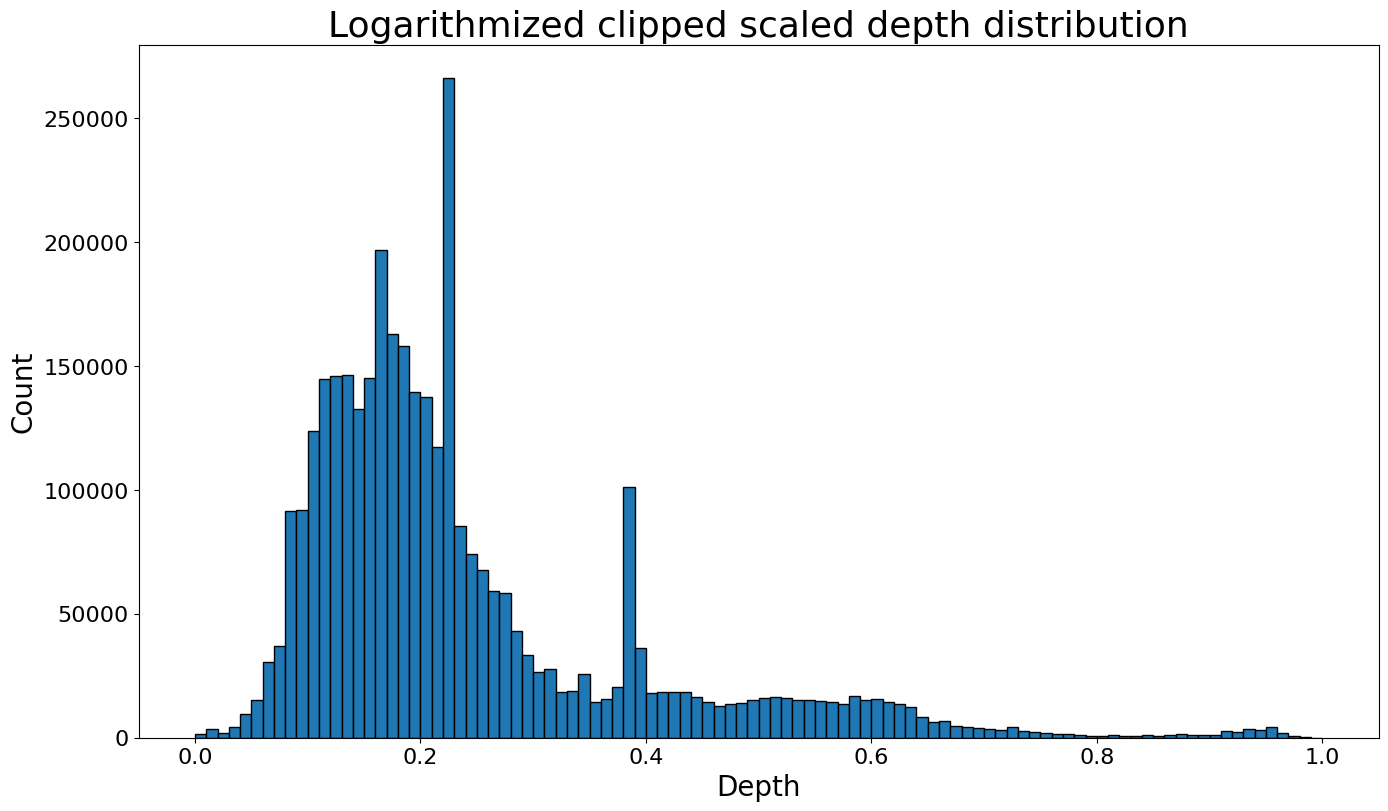

In [ ]:
scaler = MinMaxScaler()
d = scaler.fit_transform(d.values.reshape(-1, 1))
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Logarithmized clipped scaled depth distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Depth", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

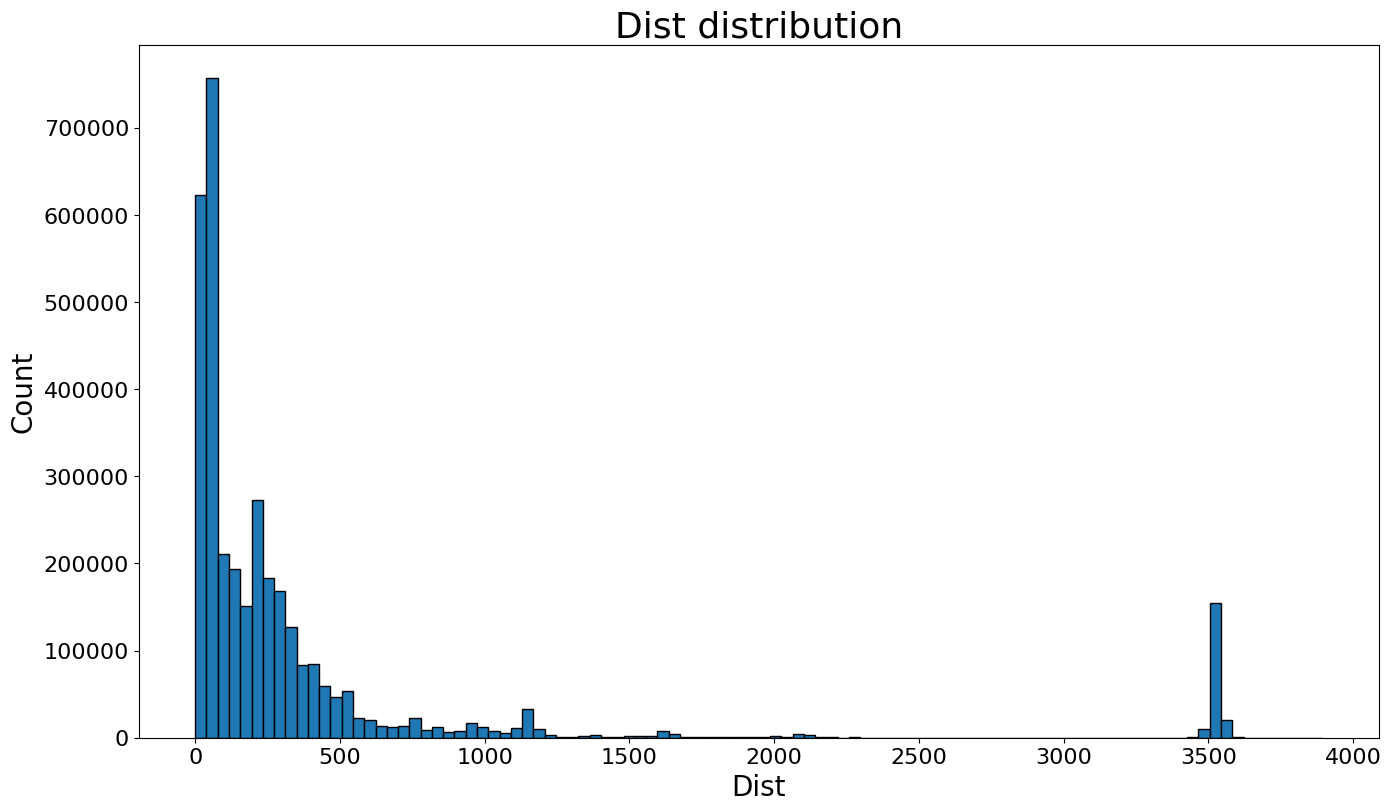

In [ ]:
tmp["dist"].hist(bins=100, edgecolor="black", figsize=(16, 9))
plt.title("Dist distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Dist", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

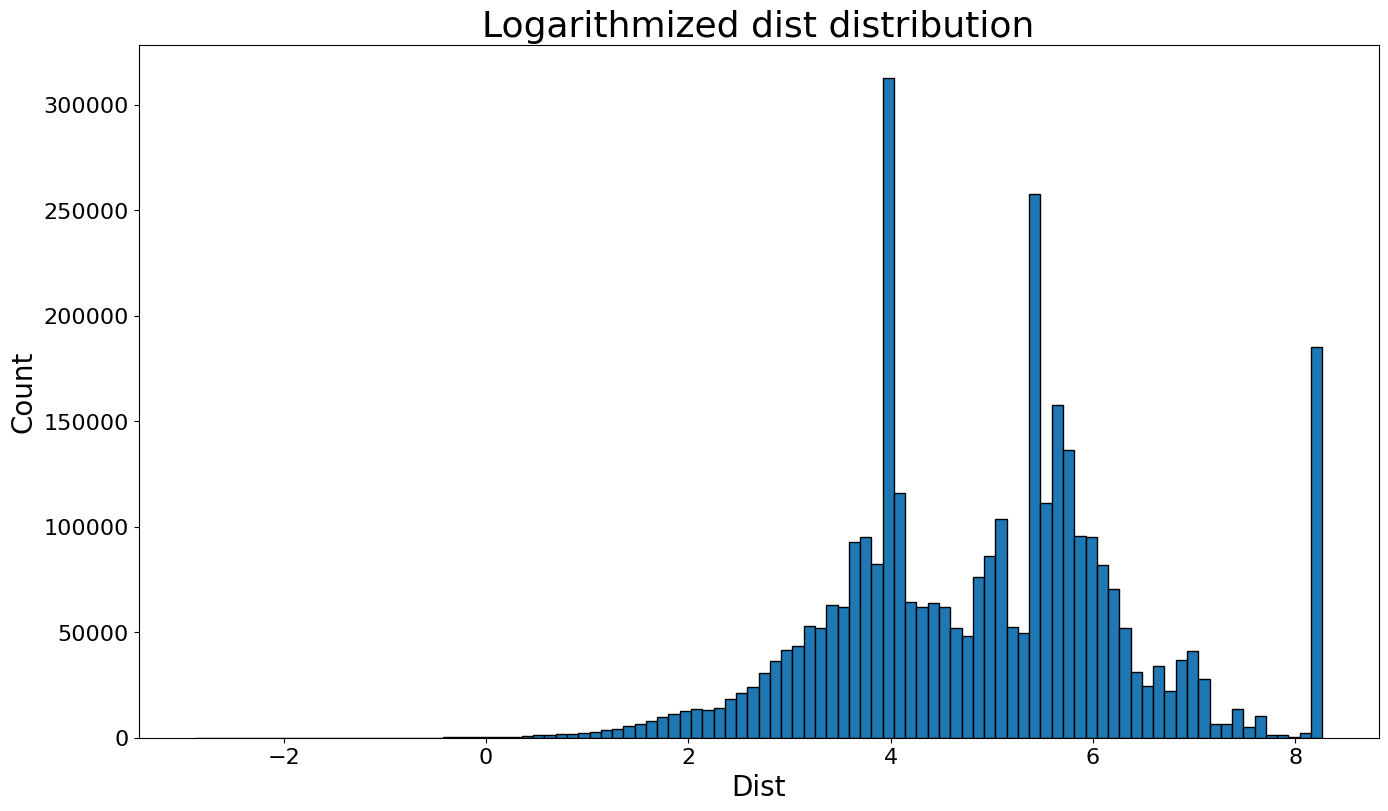

In [ ]:
d = np.log(tmp["dist"]+1e-5)
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Logarithmized dist distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Dist", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

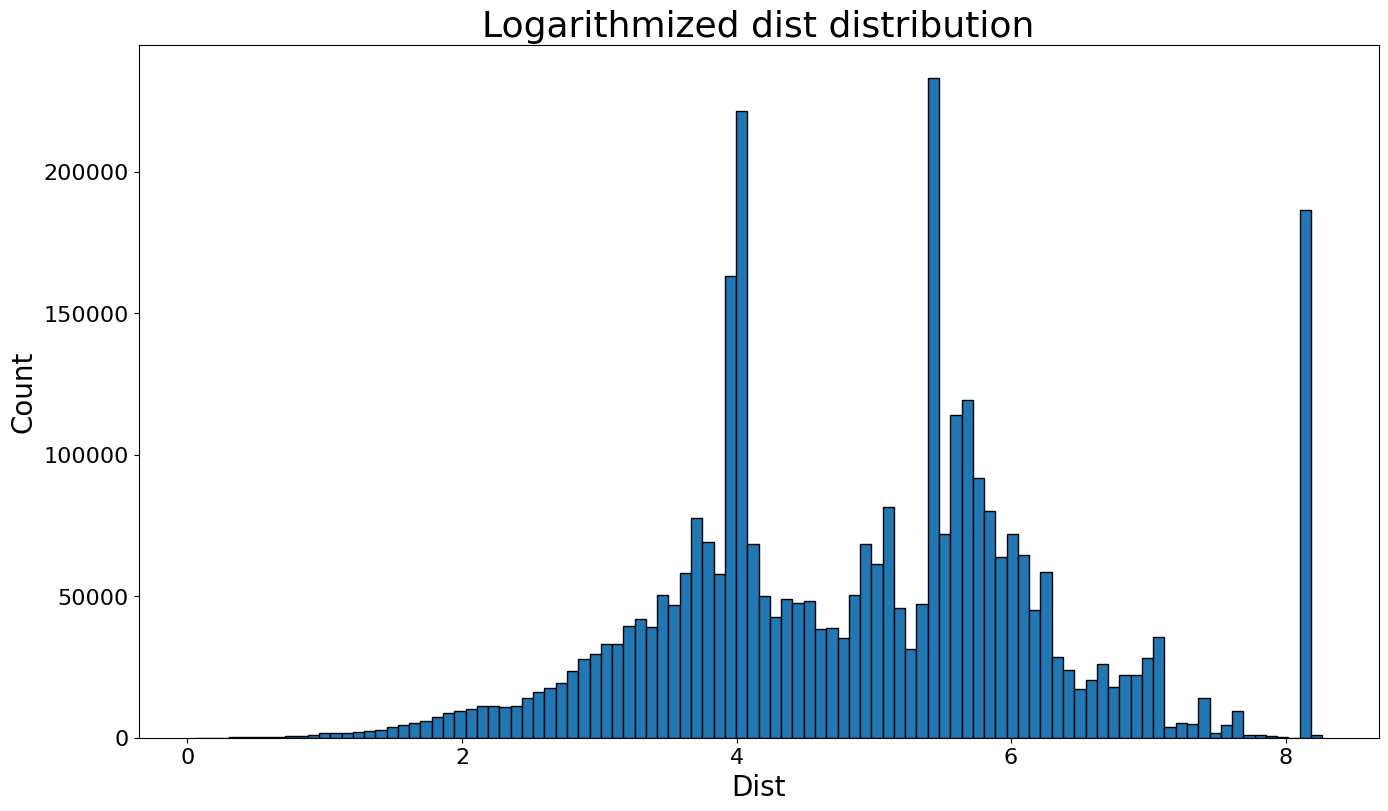

In [ ]:
d = np.log(tmp["dist"]+1)
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Logarithmized dist distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Dist", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

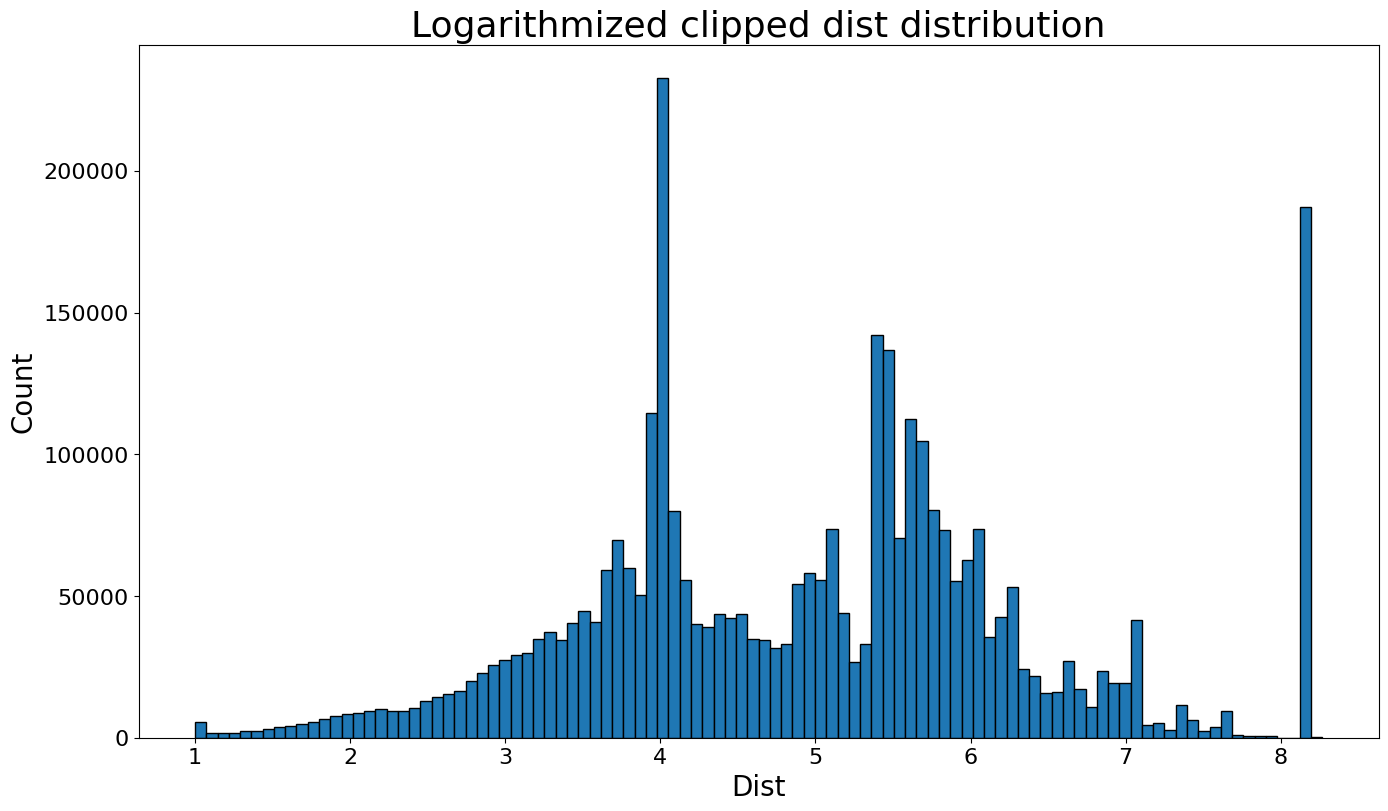

In [ ]:
d = np.clip(d, 1, 10)
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Logarithmized clipped dist distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Dist", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

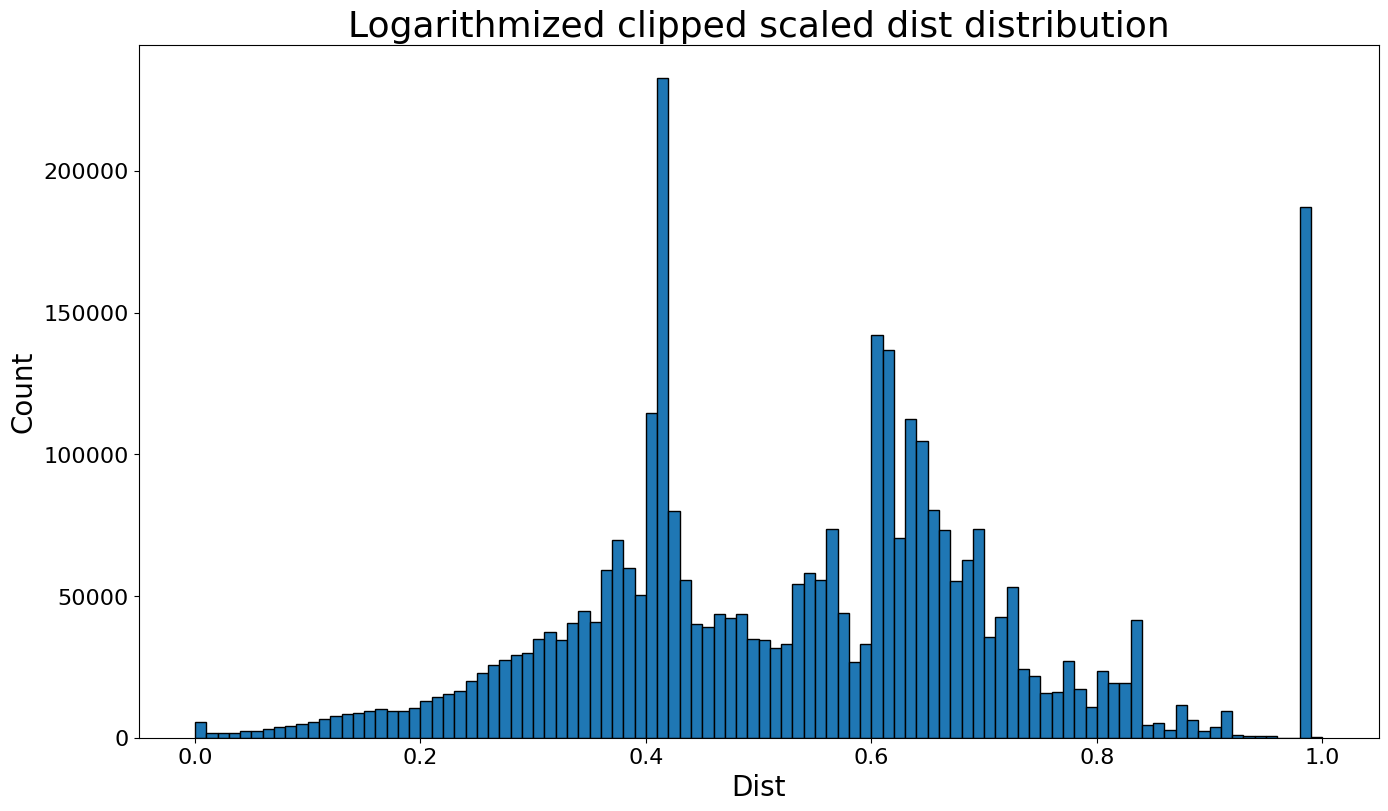

In [ ]:
scaler = MinMaxScaler()
d = scaler.fit_transform(d.values.reshape(-1, 1))
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Logarithmized clipped scaled dist distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Dist", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

In [ ]:
tmp["plate"].value_counts()

plate
na_pa       2487679
jf_pa        193188
jf_na        167693
eu_nu         73005
ca_na         59542
             ...   
CL_NB_pa          2
am_eu_yz          2
an_nu_sr          2
eu_su_yz          1
na_pa_ri          1
Name: count, Length: 250, dtype: int64

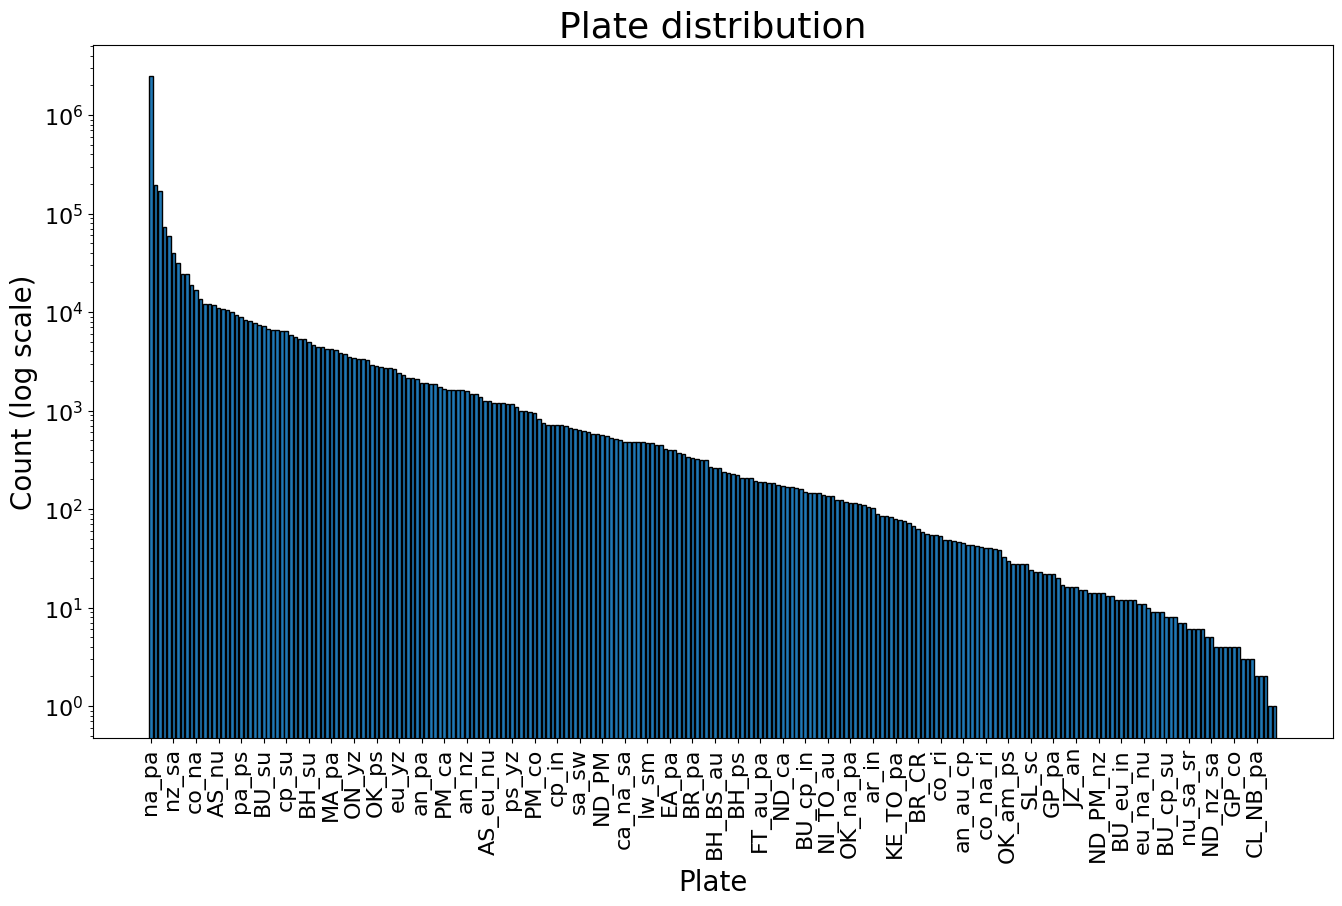

In [ ]:
plt.figure(figsize=(16, 9))
plt.bar(tmp["plate"].value_counts().index, tmp["plate"].value_counts().values, edgecolor="black")
plt.title("Plate distribution", fontsize=26)
plt.ylabel("Count (log scale)", fontsize=20)
plt.xlabel("Plate", fontsize=20)
plt.xticks(tmp["plate"].value_counts().index[::5], fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.yscale("log")
plt.show()

In [ ]:
n = 60
plate_dict = dict(zip(tmp["plate"].value_counts().index[:n], tmp["plate"].value_counts().index[:n]))
plate_dict.update(dict(zip(tmp["plate"].value_counts().index[n:], ["other"] * len(tmp["plate"].value_counts().index[n:]))))
tmp["plate_id"] = tmp["plate"].map(plate_dict)

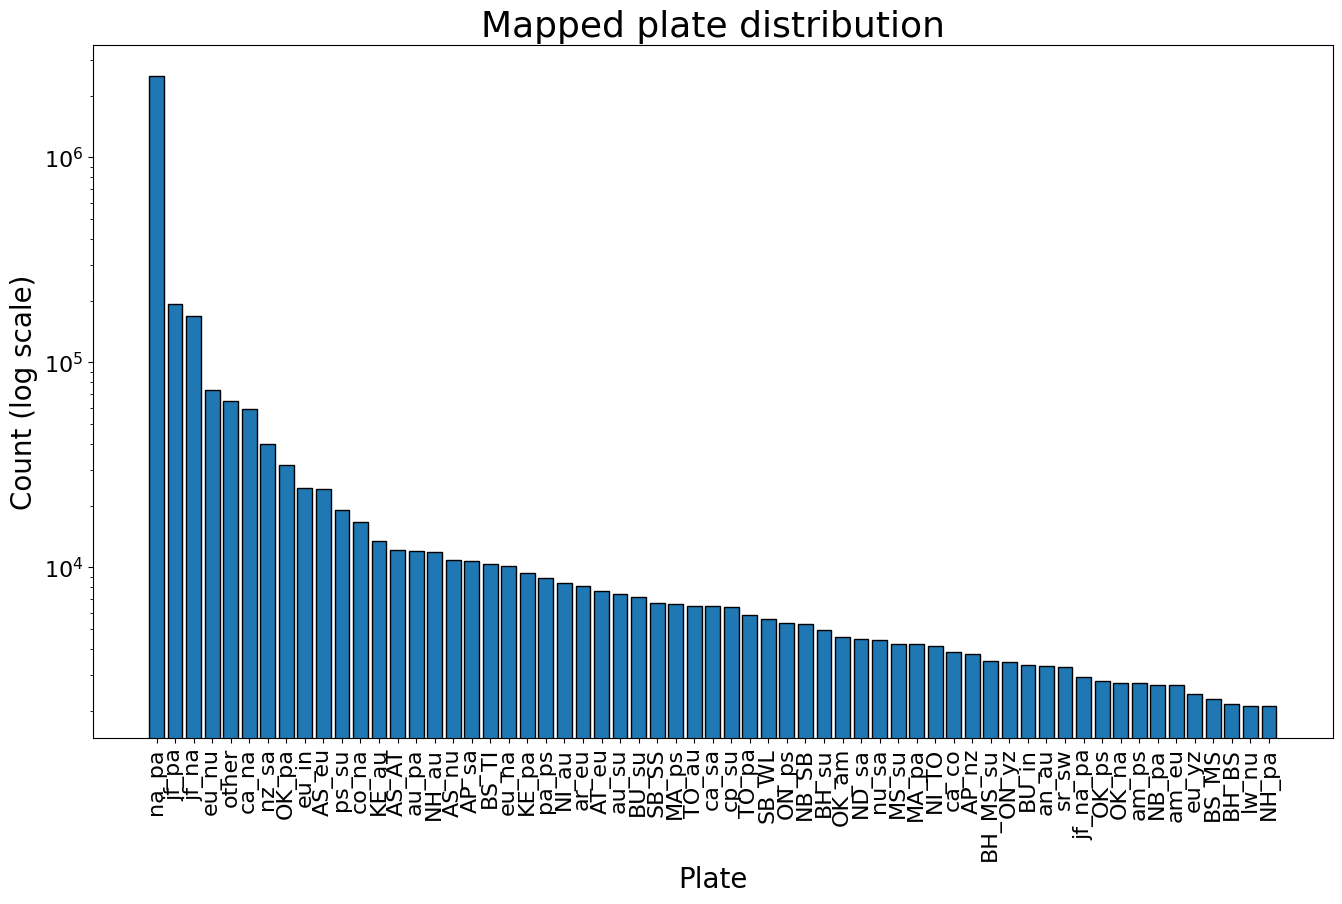

In [ ]:
plt.figure(figsize=(16, 9))
plt.bar(tmp["plate_id"].value_counts().index, tmp["plate_id"].value_counts().values, edgecolor="black")
plt.title("Mapped plate distribution", fontsize=26)
plt.ylabel("Count (log scale)", fontsize=20)
plt.xlabel("Plate", fontsize=20)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.yscale("log")
plt.show()

In [ ]:
tmp["plate_id"].value_counts()

plate_id
na_pa    2487679
jf_pa     193188
jf_na     167693
eu_nu      73005
other      65144
          ...   
eu_yz       2409
BS_MS       2289
BH_BS       2152
lw_nu       2120
NH_pa       2100
Name: count, Length: 61, dtype: int64

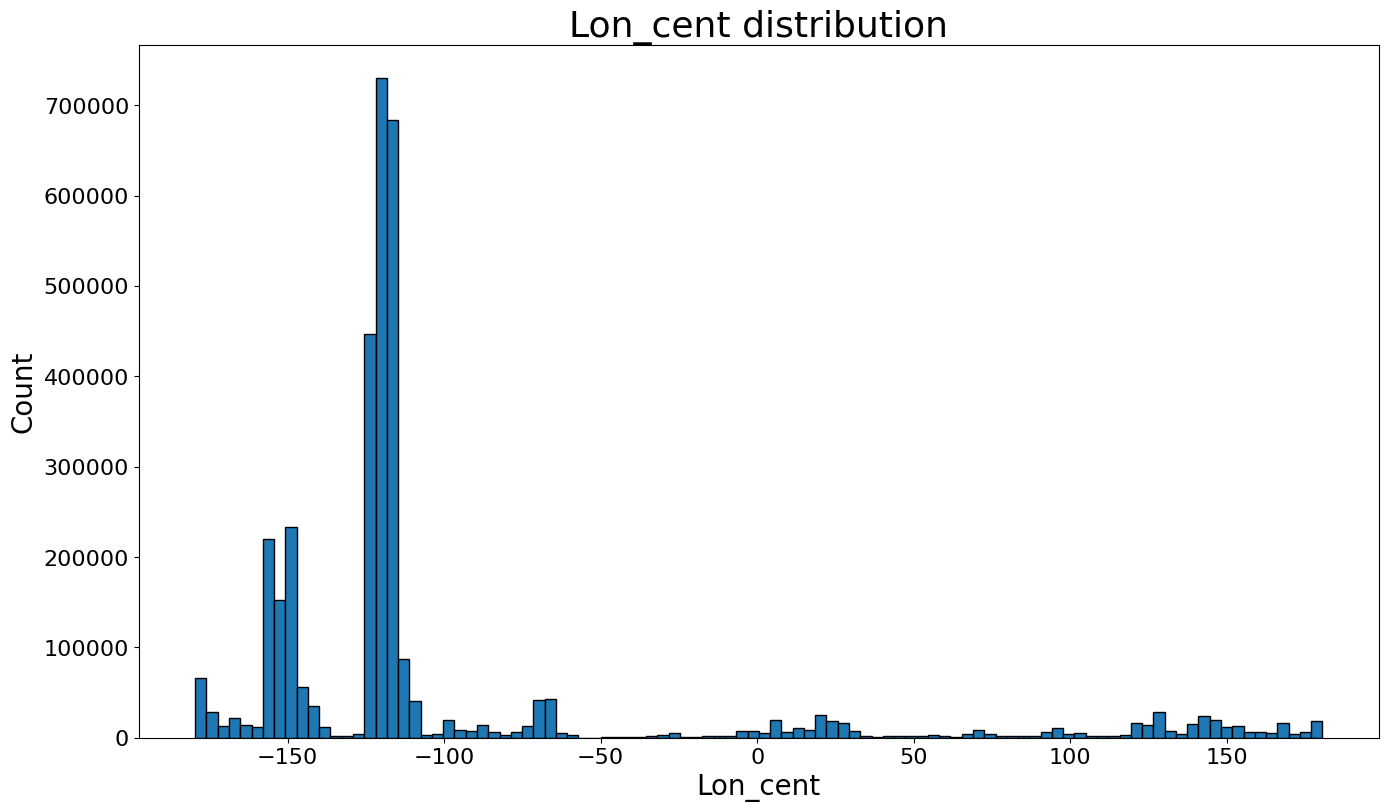

In [ ]:
tmp["lon_cent"].hist(bins=100, edgecolor="black", figsize=(16, 9))
plt.title("Lon_cent distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Lon_cent", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

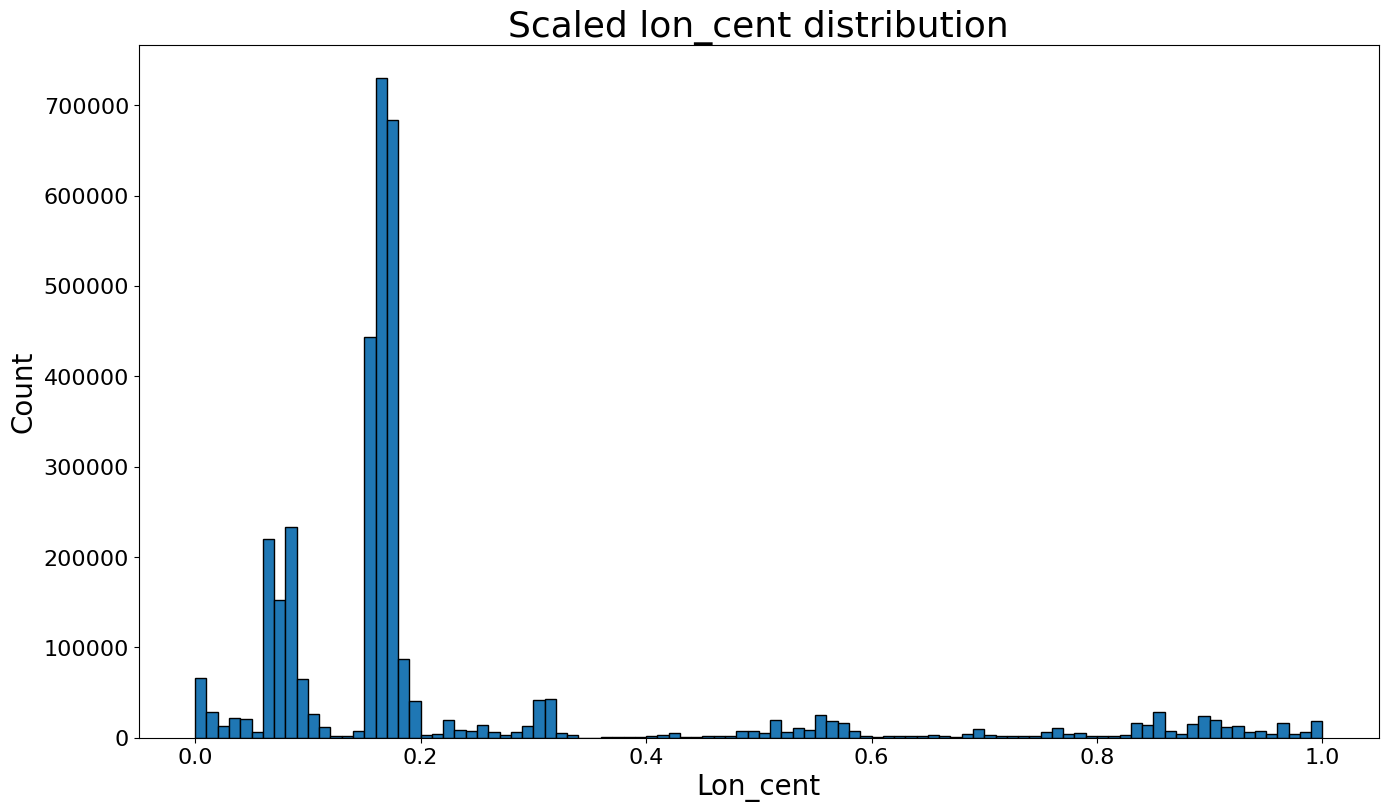

In [ ]:
scaler = MinMaxScaler()
d = scaler.fit_transform(tmp["lon_cent"].values.reshape(-1, 1))
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Scaled lon_cent distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Lon_cent", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

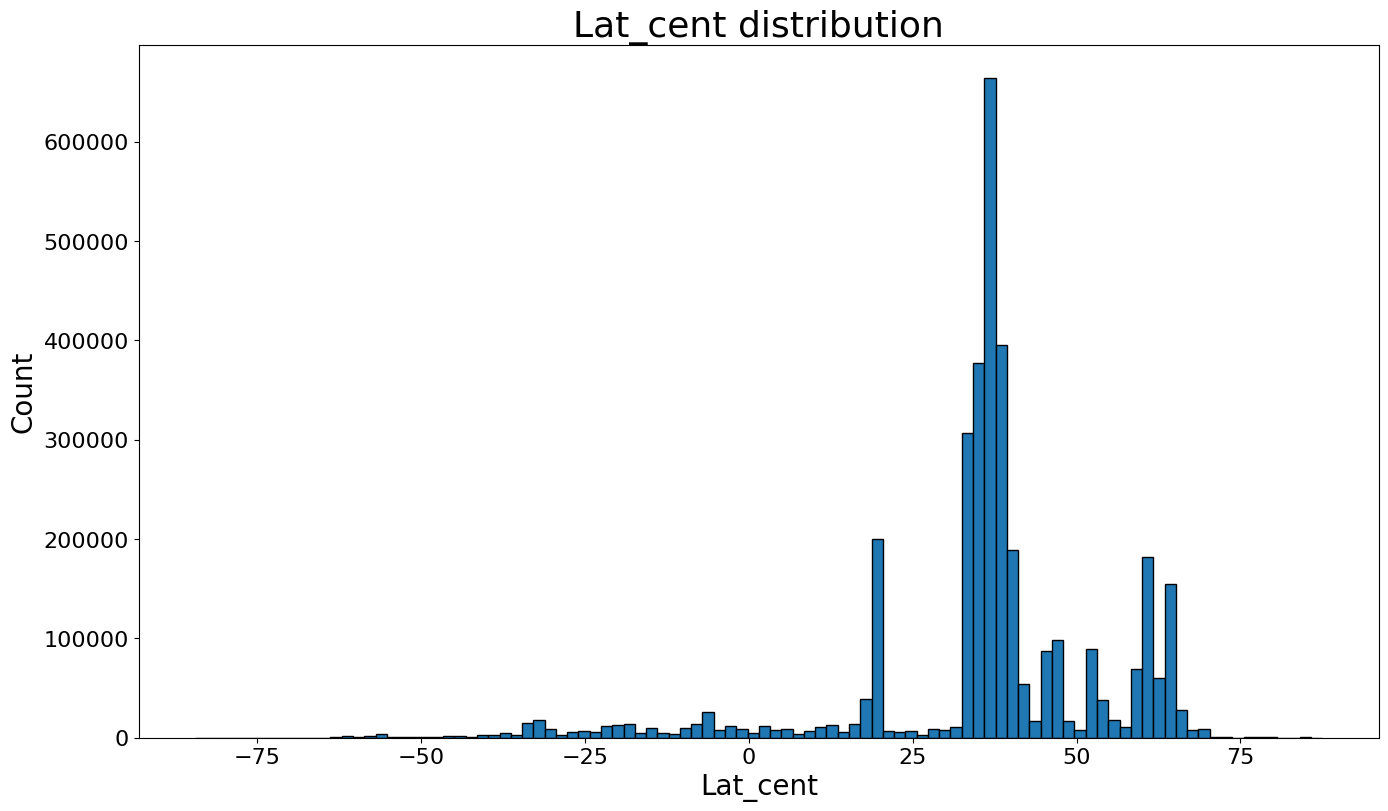

In [ ]:
tmp["lat_cent"].hist(bins=100, edgecolor="black", figsize=(16, 9))
plt.title("Lat_cent distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Lat_cent", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

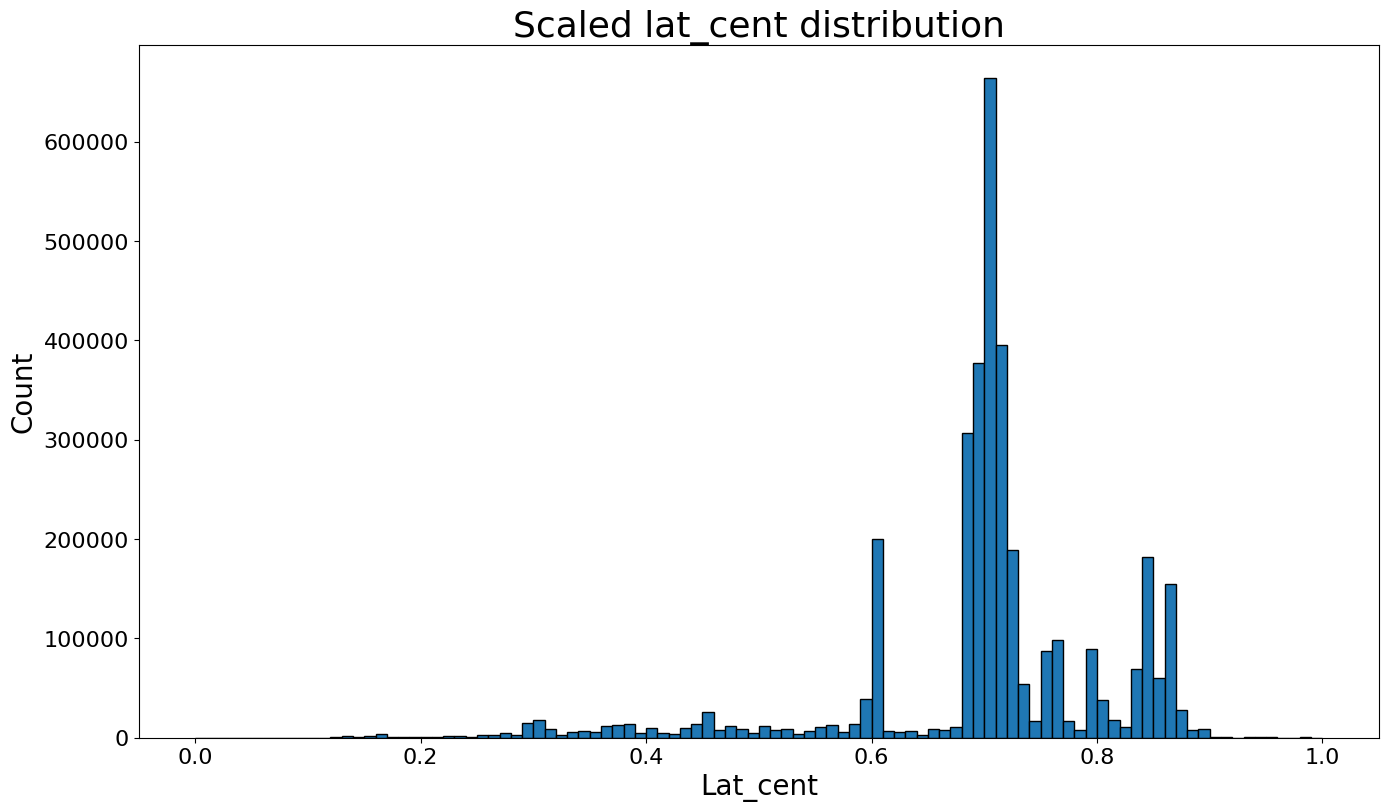

In [ ]:
scaler = MinMaxScaler()
d = scaler.fit_transform(tmp["lat_cent"].values.reshape(-1, 1))
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Scaled lat_cent distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Lat_cent", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

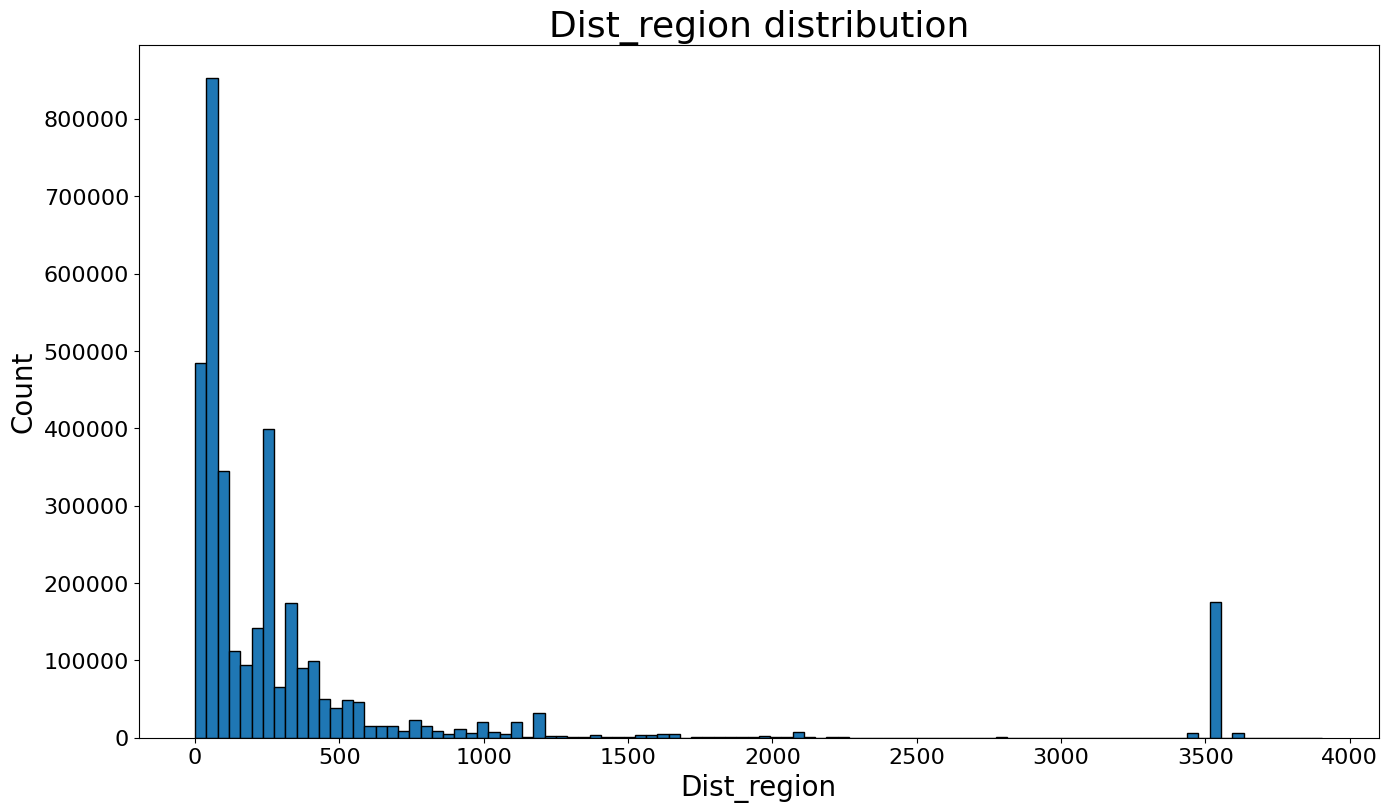

In [ ]:
tmp["dist_region"].hist(bins=100, edgecolor="black", figsize=(16, 9))
plt.title("Dist_region distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Dist_region", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

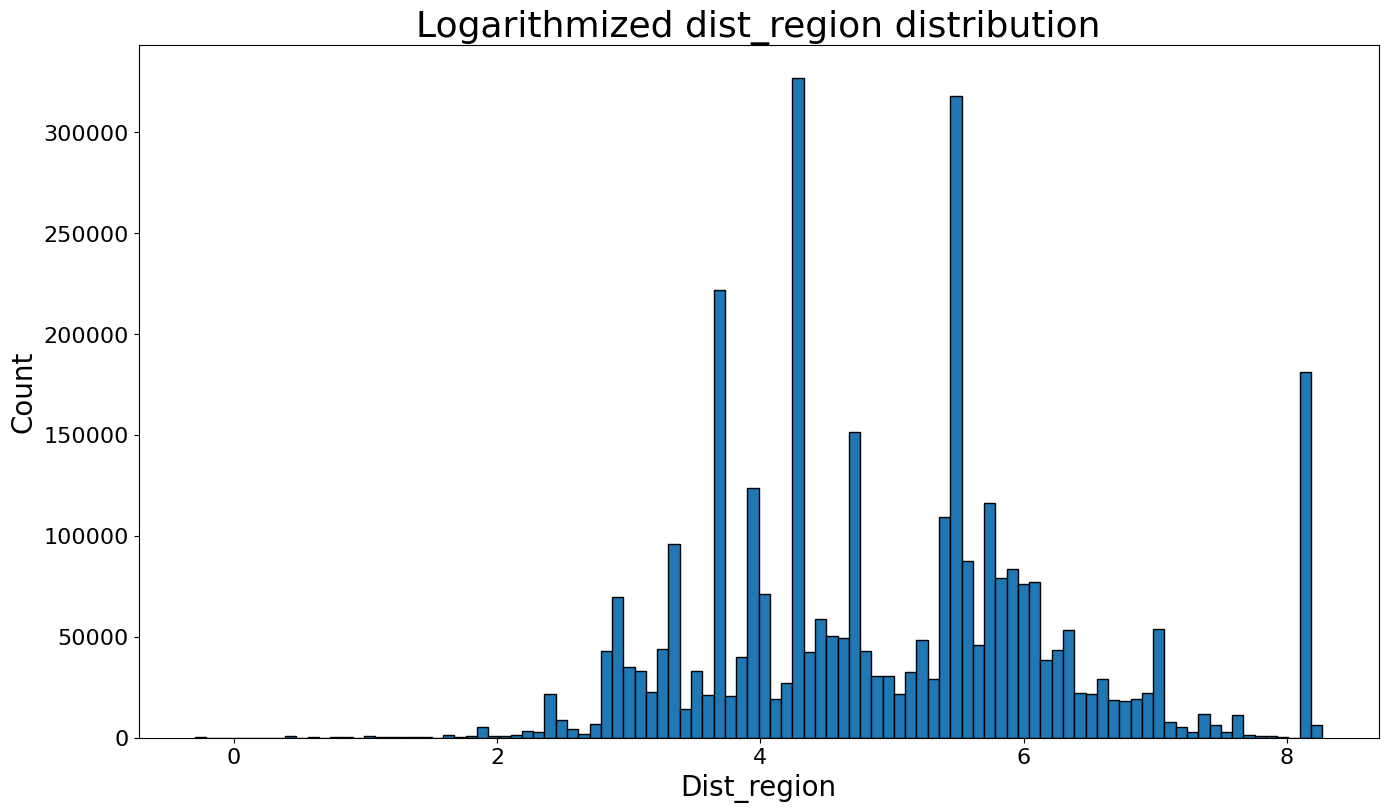

In [ ]:
d = np.log(tmp["dist_region"]+1e-5)
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Logarithmized dist_region distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Dist_region", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

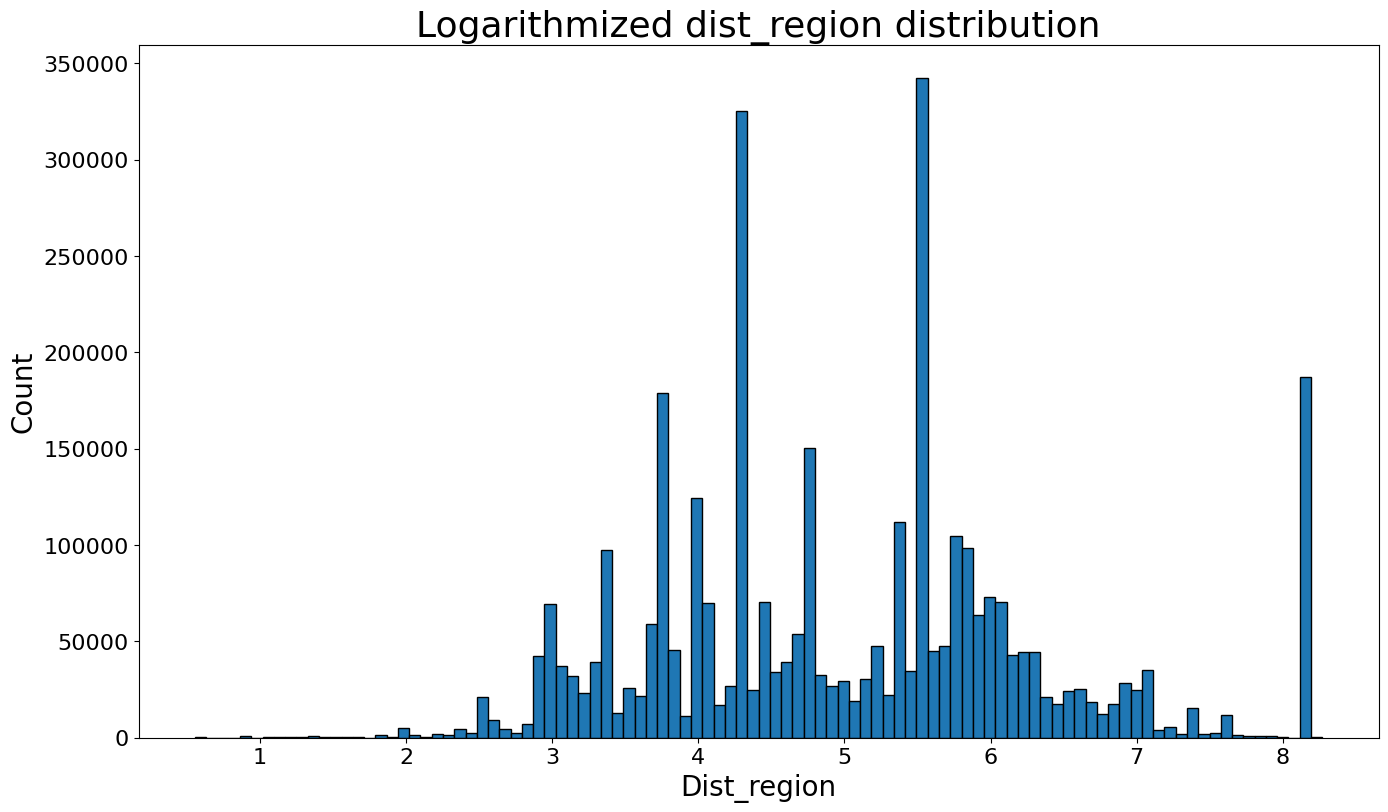

In [ ]:
d = np.log(tmp["dist_region"]+1)
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Logarithmized dist_region distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Dist_region", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

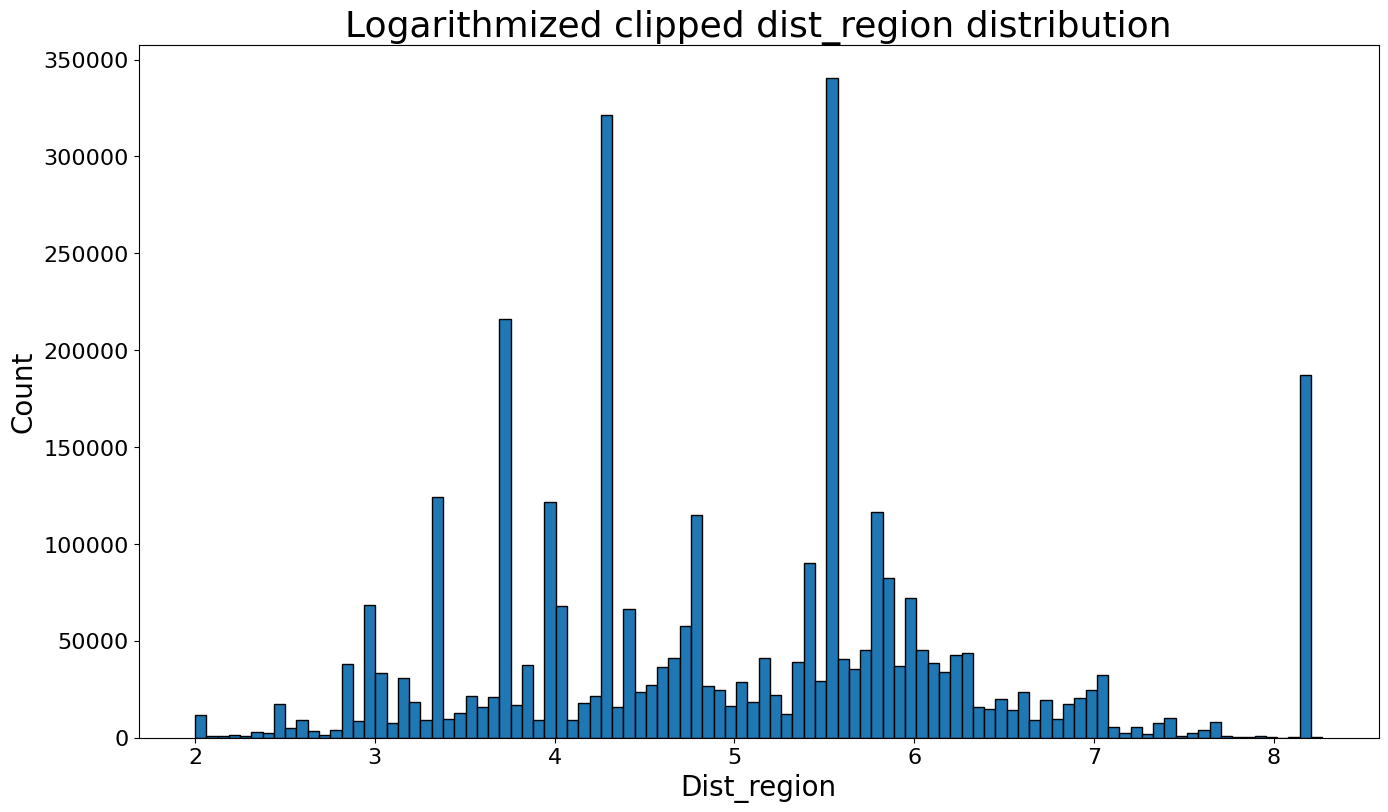

In [ ]:
d = np.clip(d, 2, 10)
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Logarithmized clipped dist_region distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Dist_region", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

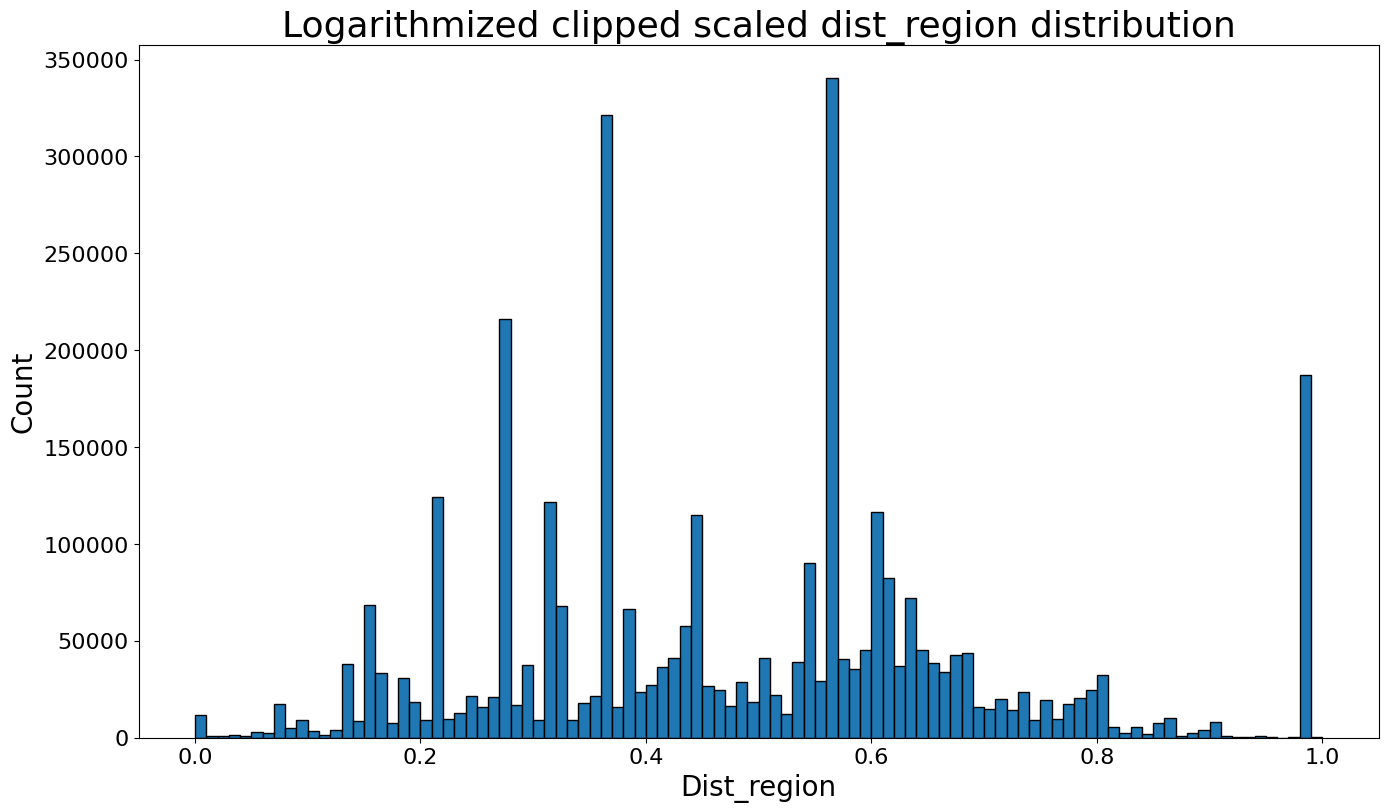

In [ ]:
scaler = MinMaxScaler()
d = scaler.fit_transform(d.values.reshape(-1, 1))
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Logarithmized clipped scaled dist_region distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Dist_region", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid(False)
plt.show()

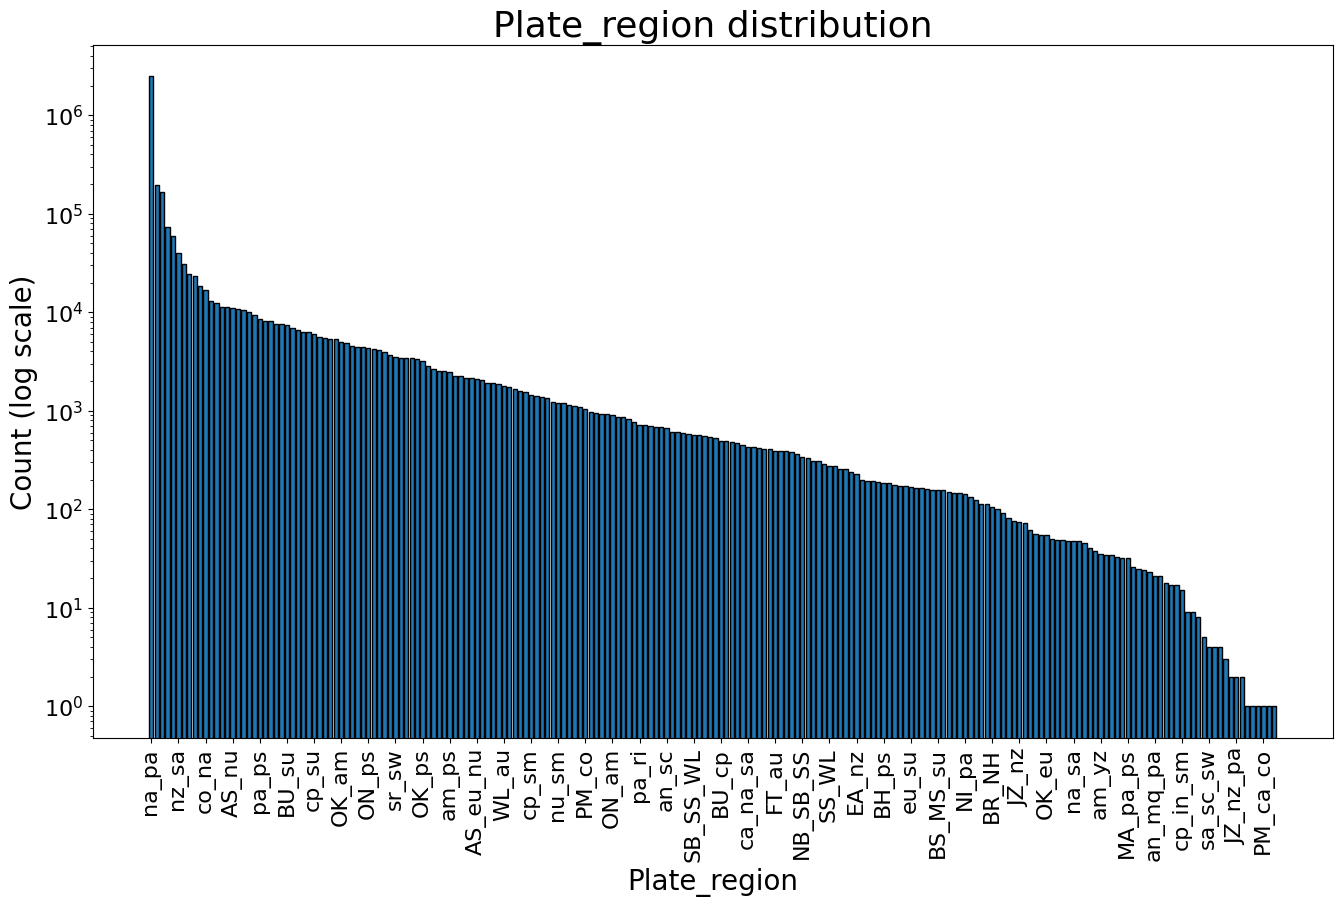

In [ ]:
plt.figure(figsize=(16, 9))
plt.bar(tmp["plate_region"].value_counts().index, tmp["plate_region"].value_counts().values, edgecolor="black")
plt.title("Plate_region distribution", fontsize=26)
plt.ylabel("Count (log scale)", fontsize=20)
plt.xlabel("Plate_region", fontsize=20)
plt.xticks(tmp["plate_region"].value_counts().index[::5], fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.yscale("log")
plt.show()

In [ ]:
n = 50
plate_dict = dict(zip(tmp["plate_region"].value_counts().index[:n], tmp["plate_region"].value_counts().index[:n]))
plate_dict.update(dict(zip(tmp["plate_region"].value_counts().index[n:], ["other"] * len(tmp["plate_region"].value_counts().index[n:]))))
tmp["plate_region_id"] = tmp["plate_region"].map(plate_dict)

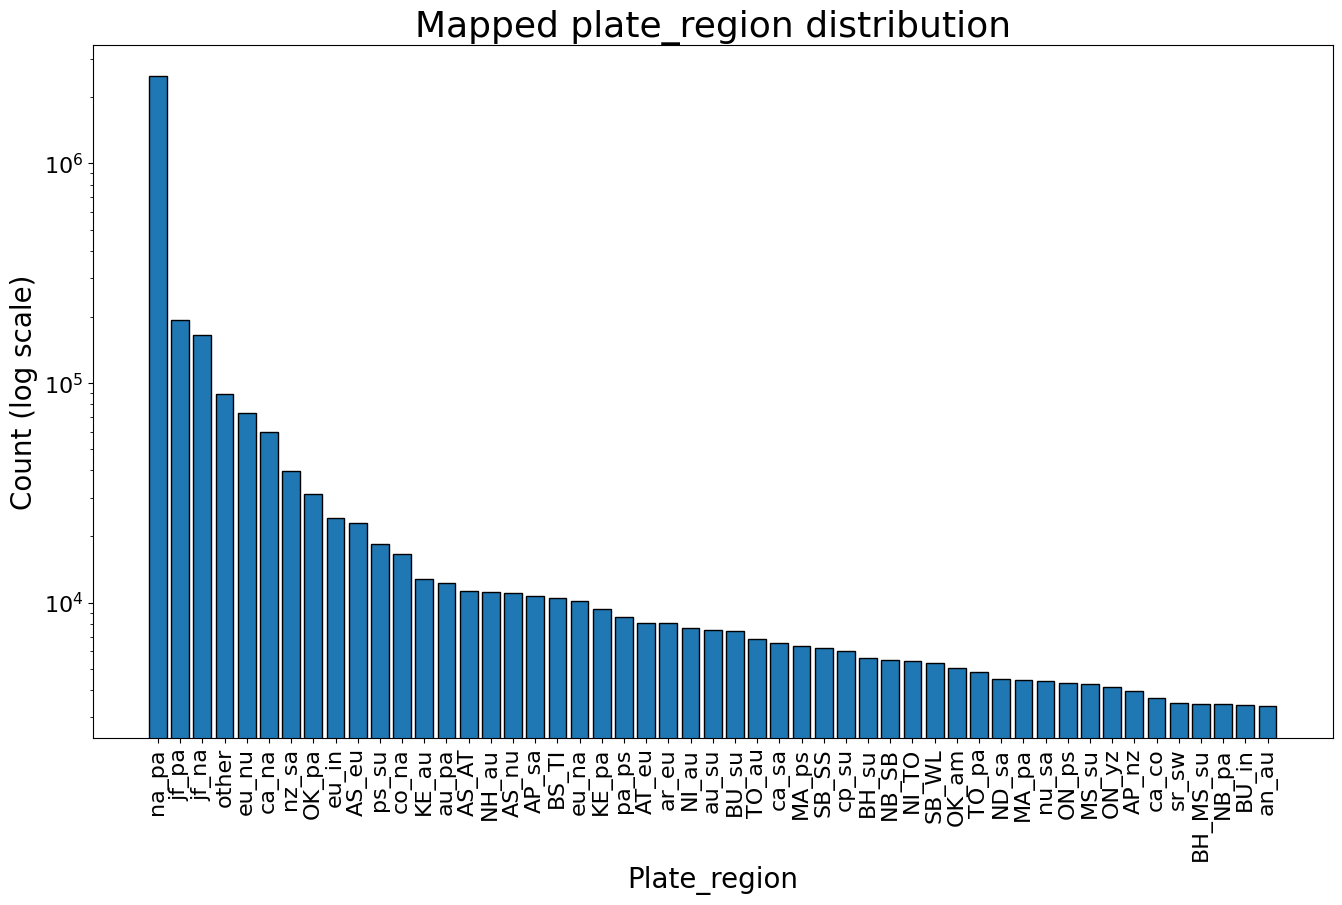

In [ ]:
plt.figure(figsize=(16, 9))
plt.bar(tmp["plate_region_id"].value_counts().index, tmp["plate_region_id"].value_counts().values, edgecolor="black")
plt.title("Mapped plate_region distribution", fontsize=26)
plt.ylabel("Count (log scale)", fontsize=20)
plt.xlabel("Plate_region", fontsize=20)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16)
plt.yscale("log")
plt.show()

In [ ]:
tmp["plate_region_id"].nunique()

51

In [4]:
tmp = pd.read_csv("../data/feature_distribution.csv")
tmp = tmp[tmp["time"] < SPLIT_DATE_TRAIN]

In [7]:
d = tmp["diff_days"].values

In [8]:
len(d) - len(d[d < 1000])

5

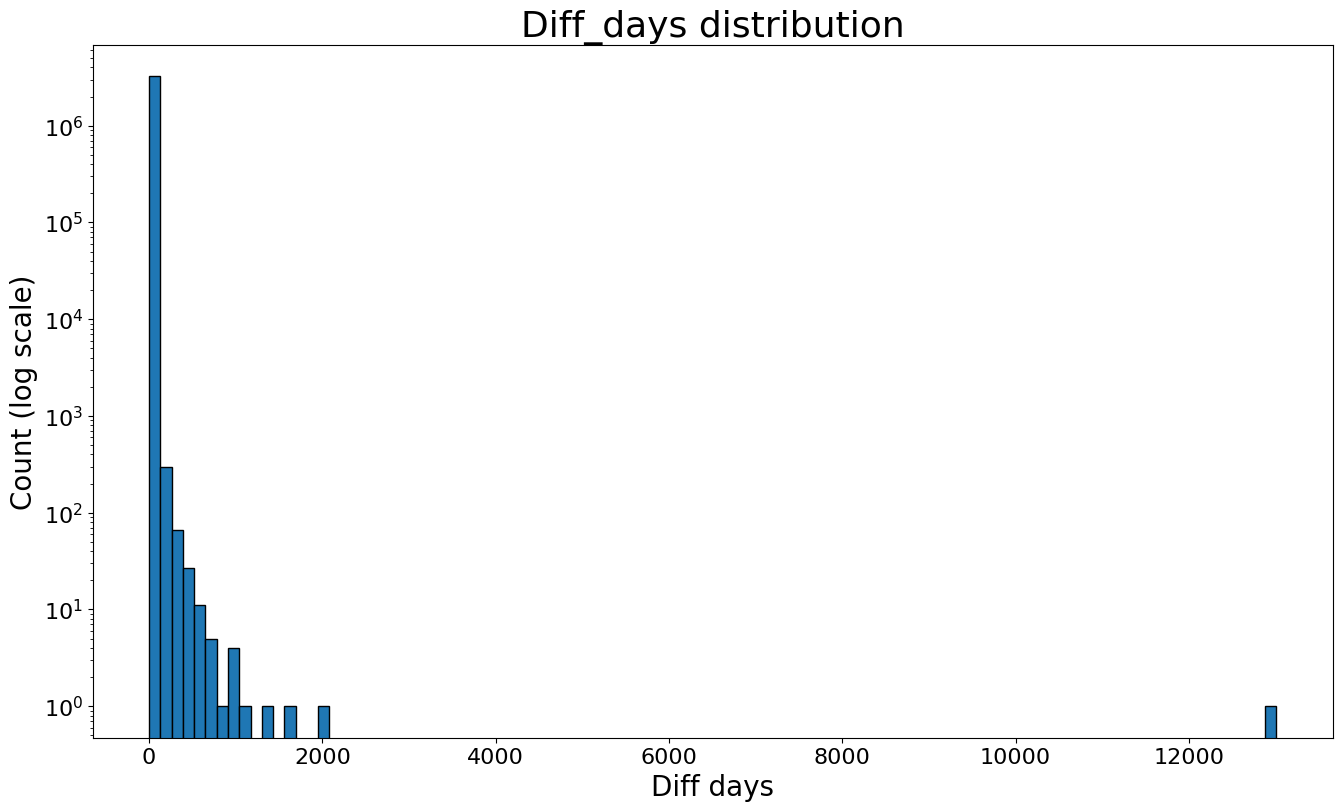

In [9]:
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Diff_days distribution", fontsize=26)
plt.ylabel("Count (log scale)", fontsize=20)
plt.xlabel("Diff days", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale("log")
plt.show()

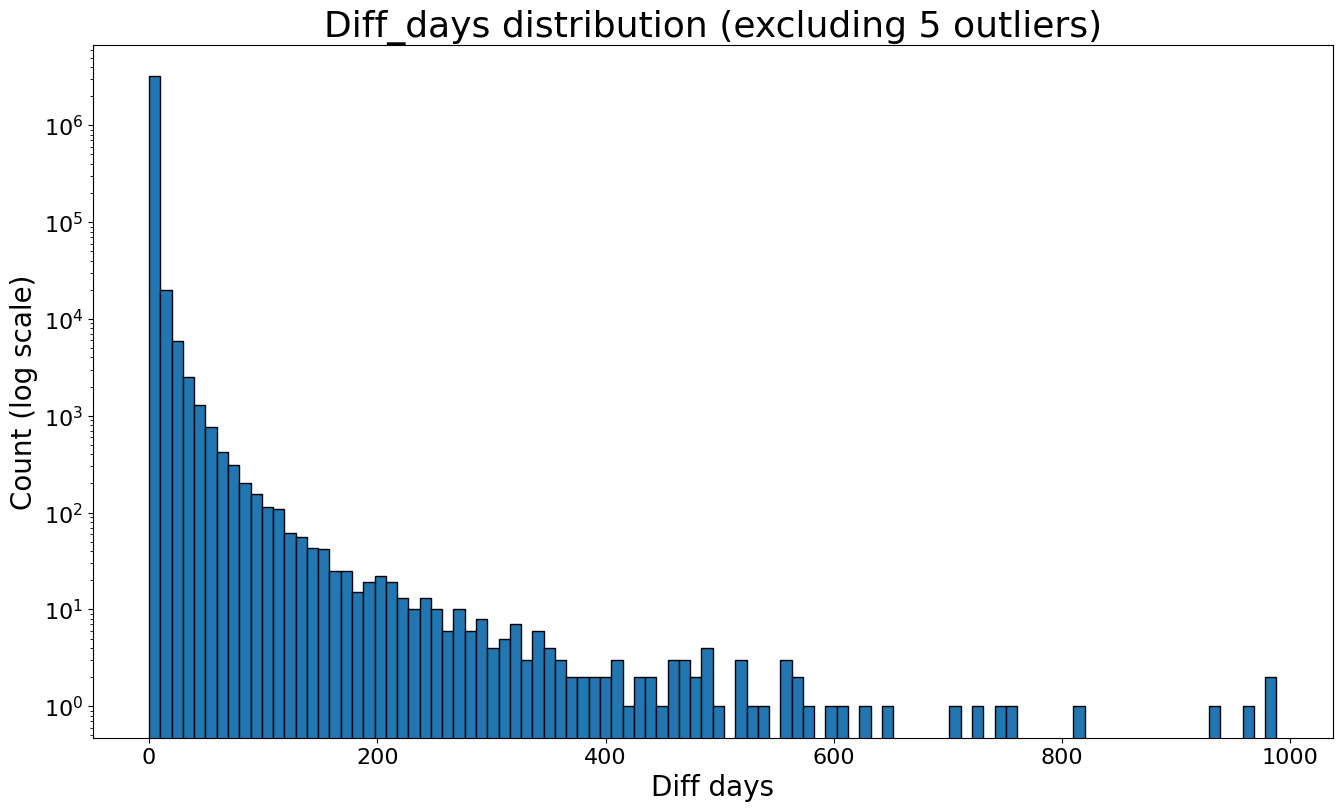

In [10]:
plt.figure(figsize=(16, 9))
plt.hist(d[d < 1000], bins=100, edgecolor="black")
plt.title("Diff_days distribution (excluding 5 outliers)", fontsize=26)
plt.ylabel("Count (log scale)", fontsize=20)
plt.xlabel("Diff days", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.yscale("log")
plt.show()

In [11]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 10, 14, 21, 30, 60, 180, 1e8]
labels = ["<1", "1", "2", "3", "4", "5", "6", "7-10", "10-14", "14-21", "21-30", "30-60", "60-180", ">180"]

In [12]:
d = np.digitize(tmp["diff_days"], bins=bins)

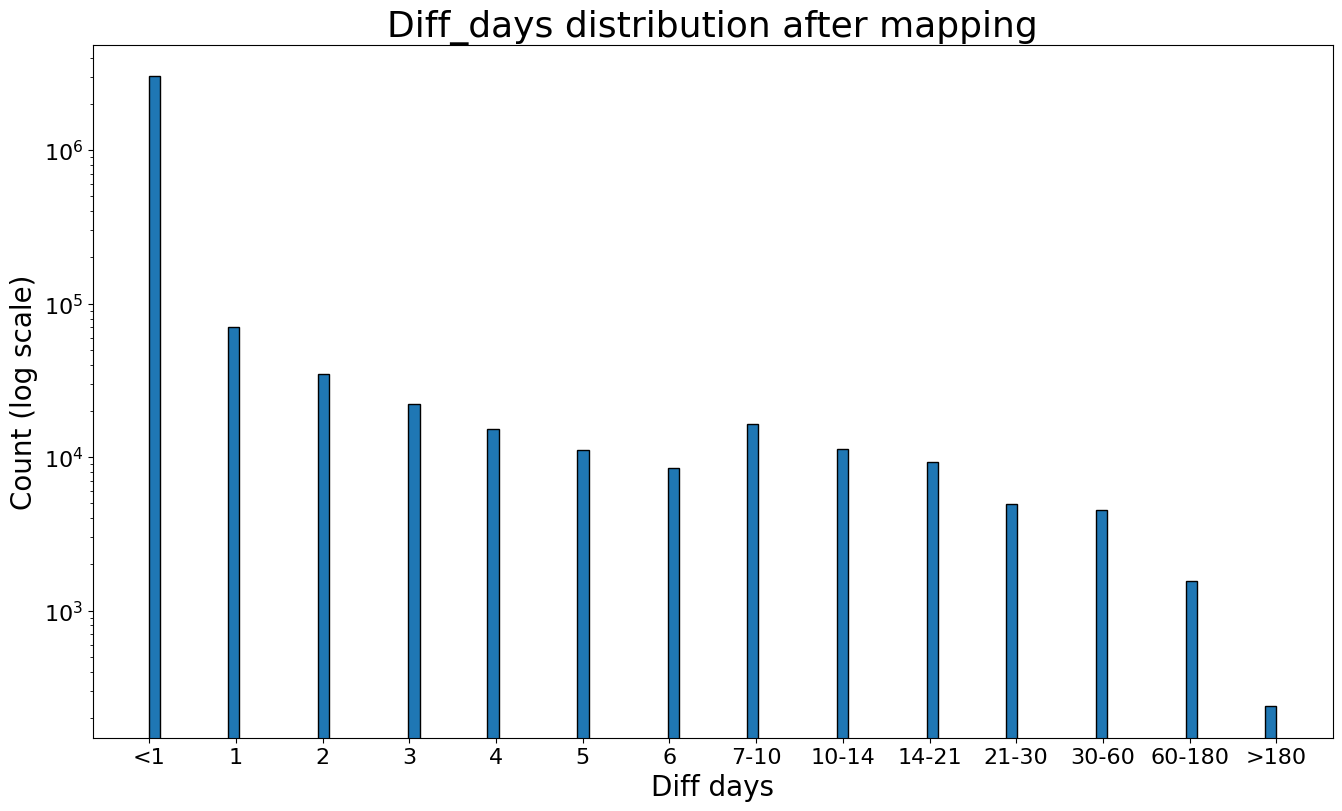

In [13]:
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.title("Diff_days distribution after mapping", fontsize=26)
plt.ylabel("Count (log scale)", fontsize=20)
plt.xlabel("Diff days", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(np.arange(1, len(bins)), labels)
plt.yscale("log")
plt.show()

In [14]:
tmp["distance"].min(), tmp["distance"].max()

(0.0, 78.2827472936967)

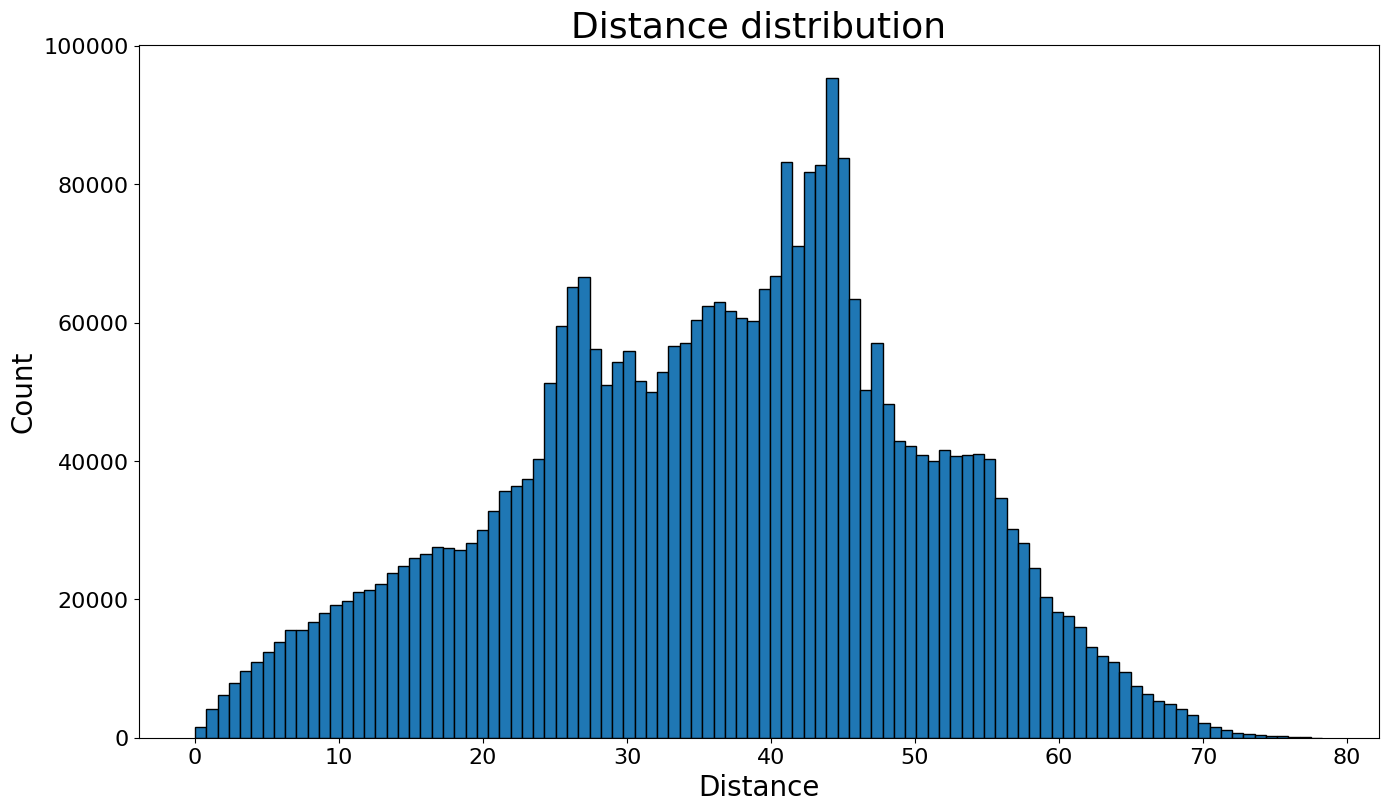

In [15]:
tmp["distance"].hist(bins=100, edgecolor="black", figsize=(16, 9))
plt.grid(False)
plt.title("Distance distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Distance", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [19]:
d = tmp["distance"].values
d = d / 78.28

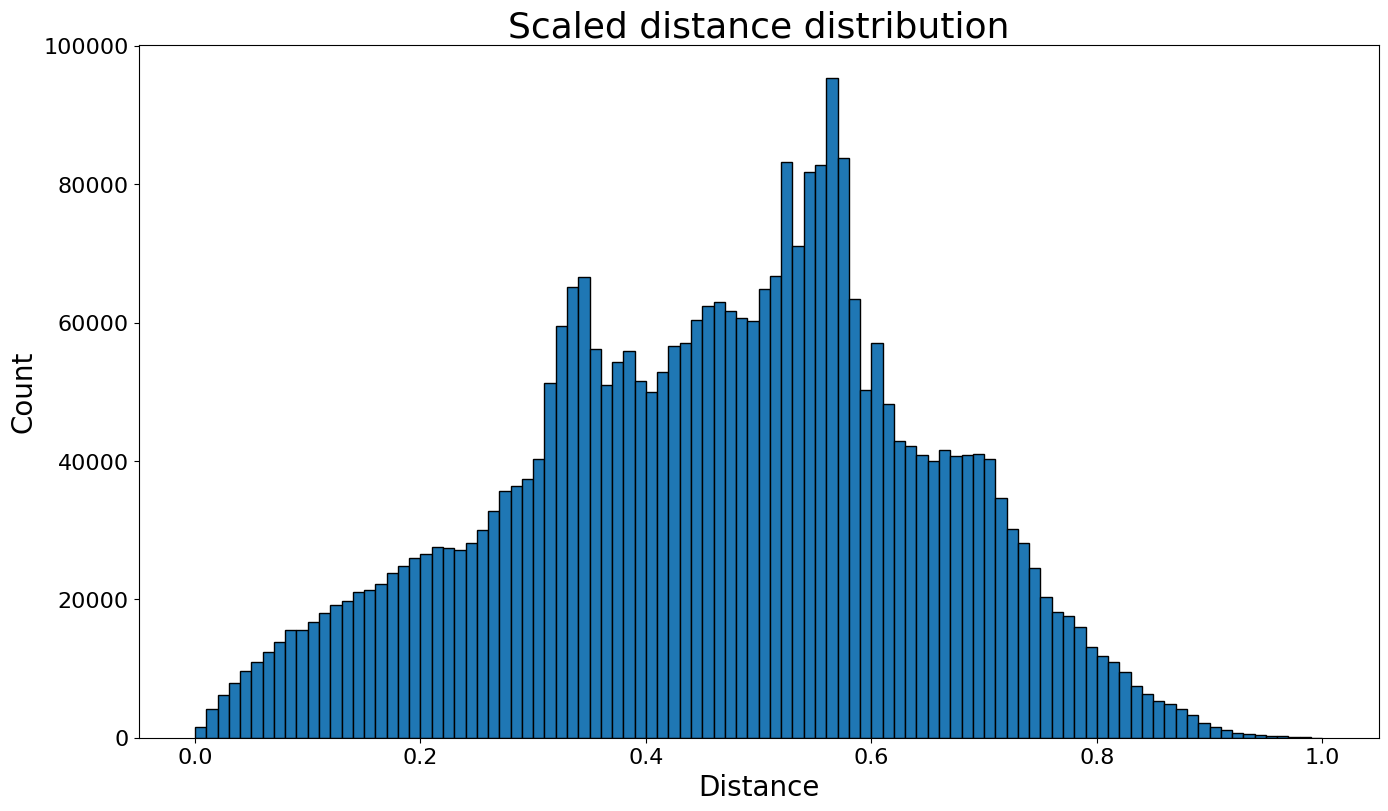

In [20]:
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.grid(False)
plt.title("Scaled distance distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Distance", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

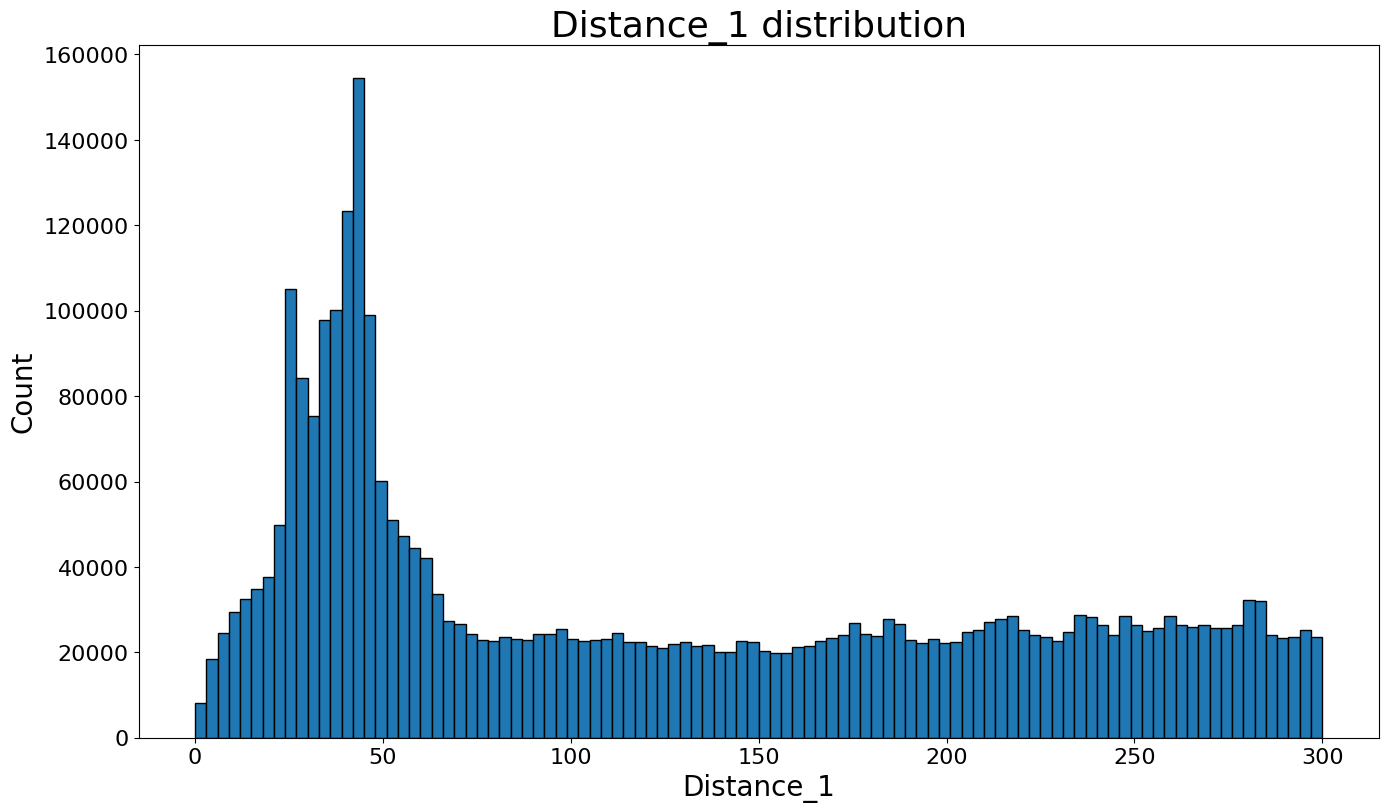

In [5]:
tmp["distance_1"].hist(bins=100, edgecolor="black", figsize=(16, 9))
plt.grid(False)
plt.title("Distance_1 distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Distance_1", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

In [6]:
d = tmp["distance_1"] / 300

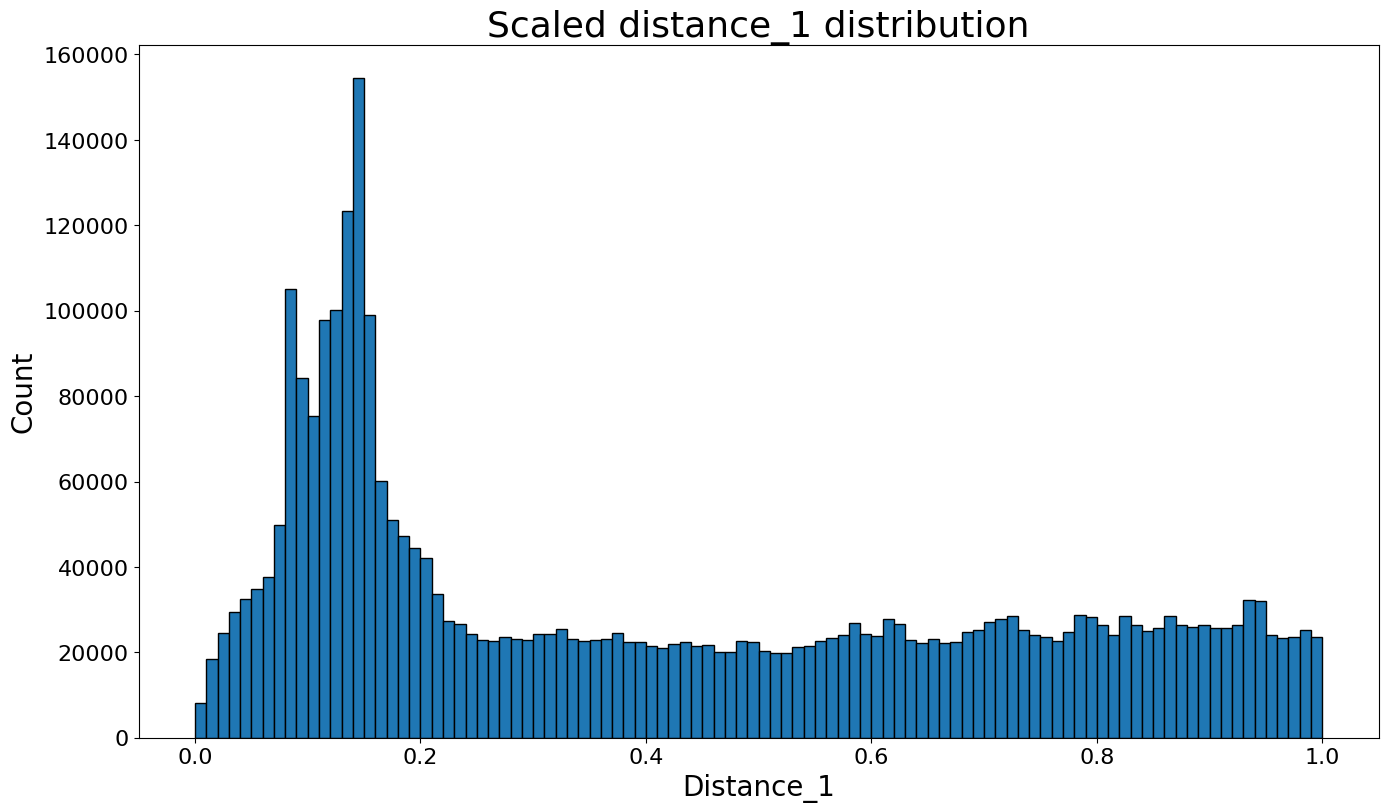

In [7]:
plt.figure(figsize=(16, 9))
plt.hist(d, bins=100, edgecolor="black")
plt.grid(False)
plt.title("Scaled distance_1 distribution", fontsize=26)
plt.ylabel("Count", fontsize=20)
plt.xlabel("Distance_1", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()